In [ ]:
! pip install scanpy
! pip install anndata
! pip install scrublet
! pip install scipy
! pip install pandas
! pip install seaborn
! pip install numpy
! pip install adjustText
! pip install celltypist
! pip install scvelo

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 16.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.7/142.7 kB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 43.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 2.4 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.6.1
    Uninstalling scikit-learn-1.6.1:
      Successfully uninstalled scikit-learn-1.6.1
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 647.5/647.5 kB 6.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for annoy: filename=annoy-1.17.3-cp311-cp311-linux_x86_64.whl size=553119 sha256=830d8f3c5524b4efd57799edefc246f23b268ef89a062c7c56d25de9a0286a47
  Stored in directory: /root/.cache/pip/wheels/33/e5/58/0a3e34b92bedf09b4c57e37a63ff395ade6f6c1099ba59877c
Successfully built annoy
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━

In [1]:
import os
import matplotlib.pyplot as plt
import anndata as ad
import scanpy as sc
import scrublet as scr
import scipy.sparse
import pandas as pd
import seaborn as sns
import numpy as np
from adjustText import adjust_text
import celltypist
from celltypist import models
import re
import scvelo as scv

ModuleNotFoundError: No module named 'anndata'

In [ ]:
# Mount google drive
from google.colab import drive
drive.mount('/content/drive')
! ls

Mounted at /content/drive
drive  sample_data


In [ ]:
# Set the working directory
working_dir = "/content/drive/MyDrive/jj/projects/2025/CarlySullivan/iteration2_all_with_cellranger/matrices/"
os.chdir(working_dir)

# Verify the current working directory
print("Current working directory:", os.getcwd())

Current working directory: /content/drive/MyDrive/jj/projects/2025/CarlySullivan/iteration2_all_with_cellranger/matrices


In [ ]:
# Set global parameters for consistency
RESOLUTION = 0.5
N_PCS = 50
N_NEIGHBORS = 10
MIN_GENES = 200
MIN_CELLS = 3
TARGET_SUM = 1e4

In [ ]:

# List of directories
directories = [
    "WT_11_5_filtered_feature_bc_matrix",
    "WT_10_5_filtered_feature_bc_matrix",
    "cKO_11_5_filtered_feature_bc_matrix",
    "cKO_10_5_filtered_feature_bc_matrix",
]
# Dictionary to store AnnData objects
my_objects = {}
for dir in directories:
    print(f"Processing directory: {dir}")
    sample = re.sub('_filtered_feature_bc_matrix', '', dir)

    if os.path.exists(dir):
        print(f"\nProcessing {sample}")
        sc_obj = sc.read_10x_mtx(dir, var_names='gene_symbols', cache=True)

        # Add a new column to distinguish KO and WT in `obs`
        sc_obj.obs["sample"] = sample  # Add sample type to metadata
        my_objects[sample] = sc_obj



        # Calculate QC metrics first - with empty list for qc_vars instead of None
        sc.pp.calculate_qc_metrics(
            sc_obj,
            inplace=True,
            percent_top=[50, 100, 200],
            qc_vars=[],  # Changed from None to empty list
            use_raw=False
        )

        # Basic filtering
        print(f"Filtering {sample}")
        sc.pp.filter_cells(sc_obj, min_genes=MIN_GENES)
        sc.pp.filter_genes(sc_obj, min_cells=MIN_CELLS)

        # MT filtering - calculate MT metrics separately
        sc_obj.var['mt'] = sc_obj.var_names.str.startswith('mt-')
        sc.pp.calculate_qc_metrics(sc_obj, qc_vars=['mt'], inplace=True)
        sc_obj = sc_obj[sc_obj.obs.pct_counts_mt < 20]

        # Normalization and transformation
        print(f"Normalizing {sample}")
        sc.pp.normalize_total(sc_obj, target_sum=TARGET_SUM)
        sc.pp.log1p(sc_obj)

        # HVG and scaling
        print(f"Processing variable genes for {sample}")
        sc.pp.highly_variable_genes(sc_obj, min_mean=0.0125, max_mean=3, min_disp=0.5)
        sc.pp.scale(sc_obj, max_value=10)

        # Dimensionality reduction
        print(f"Running PCA and UMAP for {sample}")
        sc.tl.pca(sc_obj, svd_solver='arpack', n_comps=N_PCS)
        sc.pp.neighbors(sc_obj, n_neighbors=N_NEIGHBORS, n_pcs=N_PCS)
        sc.tl.umap(sc_obj)
        sc.tl.leiden(sc_obj, resolution=RESOLUTION)

        my_objects[sample] = sc_obj

Processing directory: WT_11_5_filtered_feature_bc_matrix

Processing WT_11_5
Filtering WT_11_5
Normalizing WT_11_5
Processing variable genes for WT_11_5
Running PCA and UMAP for WT_11_5
Processing directory: WT_10_5_filtered_feature_bc_matrix

Processing WT_10_5
Filtering WT_10_5
Normalizing WT_10_5
Processing variable genes for WT_10_5
Running PCA and UMAP for WT_10_5
Processing directory: cKO_11_5_filtered_feature_bc_matrix

Processing cKO_11_5
Filtering cKO_11_5
Normalizing cKO_11_5
Processing variable genes for cKO_11_5
Running PCA and UMAP for cKO_11_5
Processing directory: cKO_10_5_filtered_feature_bc_matrix

Processing cKO_10_5
Filtering cKO_10_5
Normalizing cKO_10_5
Processing variable genes for cKO_10_5
Running PCA and UMAP for cKO_10_5


WT_11_5 contains 4258 cells and 19404 genes.


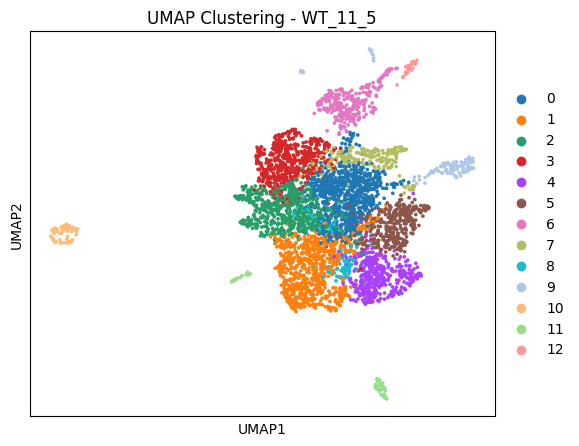

Saved top markers for WT_11_5 to WT_11_5_markers.tsv
WT_10_5 contains 4785 cells and 17373 genes.


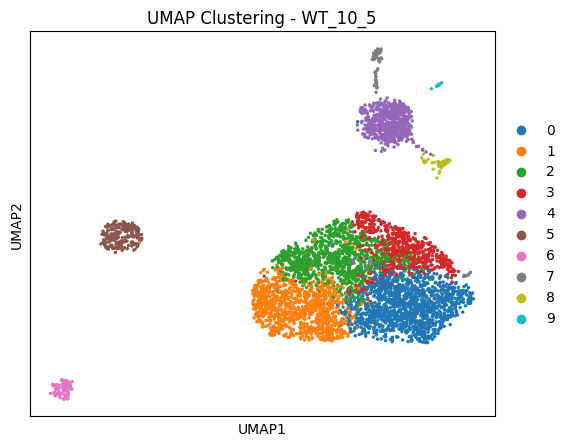

Saved top markers for WT_10_5 to WT_10_5_markers.tsv
cKO_11_5 contains 5537 cells and 19261 genes.


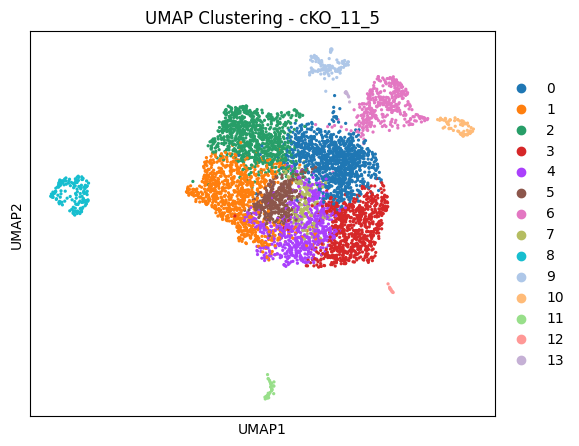

Saved top markers for cKO_11_5 to cKO_11_5_markers.tsv
cKO_10_5 contains 4243 cells and 18406 genes.


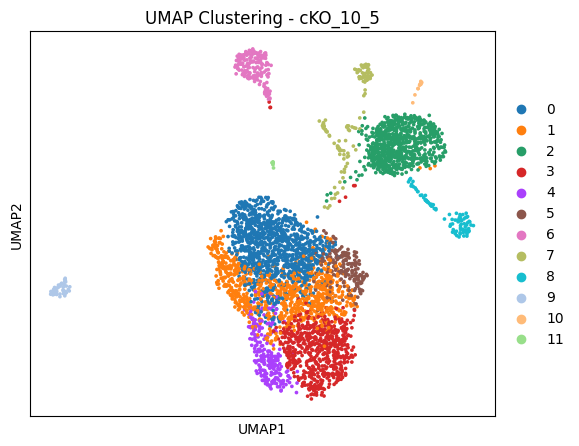

Saved top markers for cKO_10_5 to cKO_10_5_markers.tsv


In [ ]:
# First plotting loop with consistent styling
for sample, obj in my_objects.items():
    print(f"{sample} contains {obj.shape[0]} cells and {obj.shape[1]} genes.")

    fig, ax = plt.subplots(figsize=(6, 5))

    sc.pl.umap(
        obj,
        color=["leiden"],
        ax=ax,
        legend_loc='right margin',
        title=f"UMAP Clustering - {sample}",
        show=True
    )

    # Add cluster labels
    for cluster in obj.obs['leiden'].cat.categories:
        cluster_mask = obj.obs['leiden'] == cluster
        x = obj.obsm['X_umap'][cluster_mask, 0].mean()
        y = obj.obsm['X_umap'][cluster_mask, 1].mean()
        ax.text(
            x, y, cluster,
            color="black",
            fontsize=20,
            ha="center",
            va="center",
            bbox=dict(facecolor='white', alpha=0.8, edgecolor='none', pad=0.5)
        )

    plt.tight_layout()
    plt.savefig(f"{sample}_clustering_initial.png", dpi=300, bbox_inches='tight')
    plt.close()

    # Perform differential gene expression analysis per cluster
    sc.tl.rank_genes_groups(obj, groupby='leiden', method='t-test', key_added='rank_genes')

    # Save top 30 markers per cluster to a TSV file
    result = obj.uns['rank_genes']
    groups = result['names'].dtype.names  # Leiden cluster names
    marker_df = []

    for group in groups:
        df = pd.DataFrame({
            'gene': result['names'][group],
            'logfoldchanges': result['logfoldchanges'][group],
            'pvals_adj': result['pvals_adj'][group]
        })
        df = df.sort_values(by='logfoldchanges', ascending=False).head(30)  # Top 30 markers by fold change
        df['cluster'] = group
        marker_df.append(df)

    final_df = pd.concat(marker_df)
    final_df.to_csv(f"{sample}_markers.tsv", sep='\t', index=False)

    print(f"Saved top markers for {sample} to {sample}_markers.tsv")

In [ ]:
my_objects["WT_11_5"]

AnnData object with n_obs × n_vars = 4258 × 19404
    obs: 'sample', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'n_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'leiden'
    var: 'gene_ids', 'feature_types', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'mt', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'leiden', 'leiden_colors', 'rank_genes'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [ ]:

# Merge objects for E10.5 and E11.5

# List of directories
directories = [
    "WT_11_5_filtered_feature_bc_matrix",
    "WT_10_5_filtered_feature_bc_matrix",
    "cKO_11_5_filtered_feature_bc_matrix",
    "cKO_10_5_filtered_feature_bc_matrix",
]

# Dictionary to store AnnData objects
my_objects = {}

for dir in directories:
    print(f"Processing directory: {dir}")

    # Extract the sample type (e.g., E10.5_cKO or E10.5_WT)
    sample = re.sub('_filtered_feature_bc_matrix', '', dir)

    # Read the data
    if os.path.exists(dir):
        sc_obj = sc.read_10x_mtx(dir, var_names='gene_symbols', cache=True)

        # Add a new column to distinguish KO and WT in `obs`
        sc_obj.obs["sample"] = sample  # Add sample type to metadata
        my_objects[sample] = sc_obj

# Merge objects for E10.5 and E11.5
E10_5_objs = [obj for name, obj in my_objects.items() if "10_5" in name]
E10_5_obj = sc.concat(E10_5_objs, join="outer", label="batch", keys=["cKO_10_5", "WT_10_5"], index_unique=None)

E11_5_objs = [obj for name, obj in my_objects.items() if "11_5" in name]
E11_5_obj = sc.concat(E11_5_objs, join="outer", label="batch", keys=["cKO_11_5", "WT_11_5"], index_unique=None)


# Print results
print(f"E10_5_obj contains {E10_5_obj.shape[0]} cells and {E10_5_obj.shape[1]} genes.")
print(f"E11_5_obj contains {E11_5_obj.shape[0]} cells and {E11_5_obj.shape[1]} genes.")




Processing directory: WT_11_5_filtered_feature_bc_matrix
Processing directory: WT_10_5_filtered_feature_bc_matrix
Processing directory: cKO_11_5_filtered_feature_bc_matrix
Processing directory: cKO_10_5_filtered_feature_bc_matrix
E10_5_obj contains 9039 cells and 32285 genes.
E11_5_obj contains 9804 cells and 32285 genes.


In [ ]:
# E10_5
# Verify uniqueness in dataset
e10_5_n_duplicates = sum(E10_5_obj.obs_names.duplicated())

if e10_5_n_duplicates > 0:
    print(f"Warning: {e10_5_n_duplicates} duplicate observations found in combined dataset")
    E10_5_obj.obs_names_make_unique()

# Determine some QC parameters
# mitochondrial genes, "MT-" for human, "mt-" for mouse
# Adjust mitochondrial gene identification for mouse data
E10_5_obj.var["mt"] = E10_5_obj.var_names.str.startswith(("mt-"))

# ribosomal genes
E10_5_obj.var["ribo"] = E10_5_obj.var_names.str.startswith(("Rps", "Rpl"))

sc.pp.calculate_qc_metrics(
E10_5_obj, qc_vars=["mt", "ribo"], inplace=True, log1p=True
)


In [ ]:
# E11_5
# Verify uniqueness in dataset
e11_5_n_duplicates = sum(E11_5_obj.obs_names.duplicated())

if e11_5_n_duplicates > 0:
    print(f"Warning: {e11_5_n_duplicates} duplicate observations found in combined dataset")
    E11_5_obj.obs_names_make_unique()

# Determine some QC parameters
# mitochondrial genes, "MT-" for human, "Mt-" for mouse
# Adjust mitochondrial gene identification for mouse data
E11_5_obj.var["mt"] = E11_5_obj.var_names.str.startswith(("mt-"))

# ribosomal genes
E11_5_obj.var["ribo"] = E11_5_obj.var_names.str.startswith(("Rps", "Rpl"))

sc.pp.calculate_qc_metrics(
E11_5_obj, qc_vars=["mt", "ribo"], inplace=True, log1p=True
)

In [ ]:
print("First few gene names 10.5:")
print(E10_5_obj.var_names[:5])
print("\nFirst few cell barcodes 10.5:")
print(E10_5_obj.obs_names[:5])

print("First few gene names 11.5:")
print(E11_5_obj.var_names[:5])
print("\nFirst few cell barcodes 11.5:")
print(E11_5_obj.obs_names[:5])

First few gene names 10.5:
Index(['Xkr4', 'Gm1992', 'Gm19938', 'Gm37381', 'Rp1'], dtype='object')

First few cell barcodes 10.5:
Index(['AAACCCAAGACACACG-1', 'AAACCCAAGTGCCGAA-1', 'AAACCCACACACACGC-1',
       'AAACCCACACCCAAGC-1', 'AAACGAAAGGTCACAG-1'],
      dtype='object')
First few gene names 11.5:
Index(['Xkr4', 'Gm1992', 'Gm19938', 'Gm37381', 'Rp1'], dtype='object')

First few cell barcodes 11.5:
Index(['AAACCCAAGAATACAC-1', 'AAACCCAAGATTGCGG-1', 'AAACCCACAAGCGCAA-1',
       'AAACCCACAAGCGGAT-1', 'AAACCCACAGCCTTCT-1'],
      dtype='object')


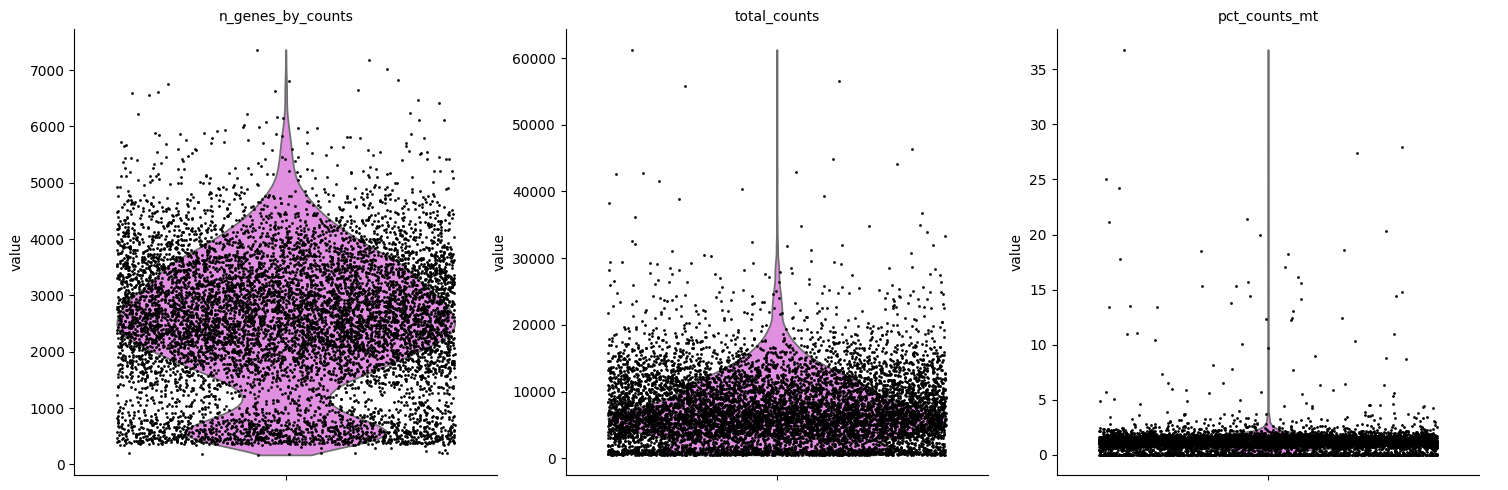

In [ ]:
output_file = "_10_5_plot_beforeFiltering.png"
sc.pl.violin(
    E10_5_obj,
    ["n_genes_by_counts", "total_counts", "pct_counts_mt"],
    jitter=0.4,
    color="violet",
    size=2,
    multi_panel=True,
    save=output_file
)

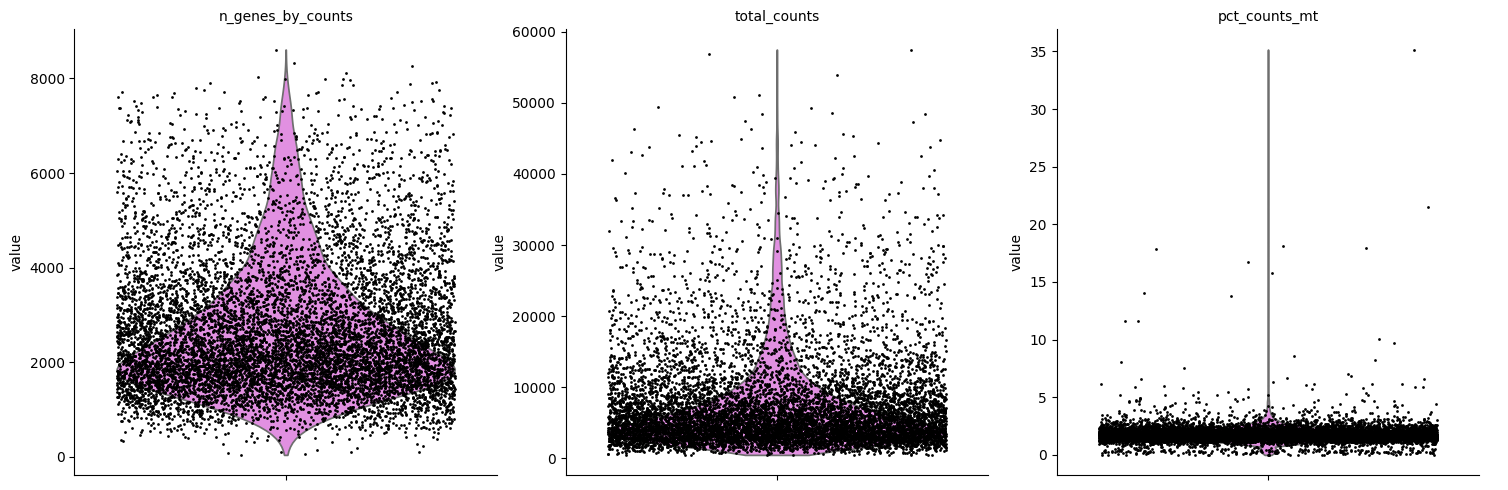

In [ ]:
output_file = "_11.5_plot_beforeFiltering.png"
sc.pl.violin(
    E11_5_obj,
    ["n_genes_by_counts", "total_counts", "pct_counts_mt"],
    jitter=0.4,
    color="violet",
    size=2,
    multi_panel=True,
    save=output_file
)

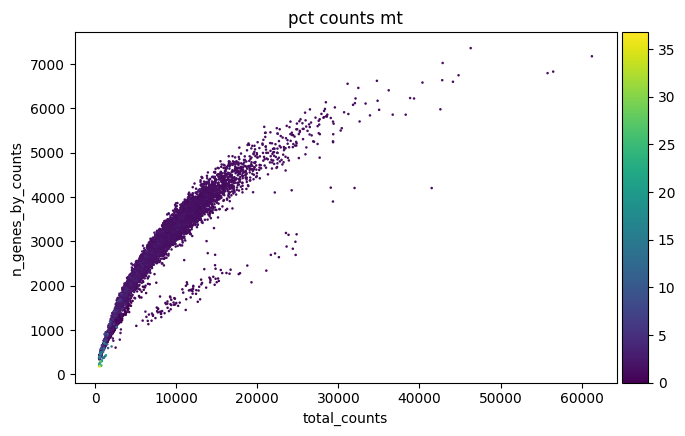

In [ ]:
output_file = "_10.5_plot_beforeFiltering.png"
sc.pl.scatter(
    E10_5_obj,
    "total_counts",
    "n_genes_by_counts",
    color="pct_counts_mt",
    save=output_file)

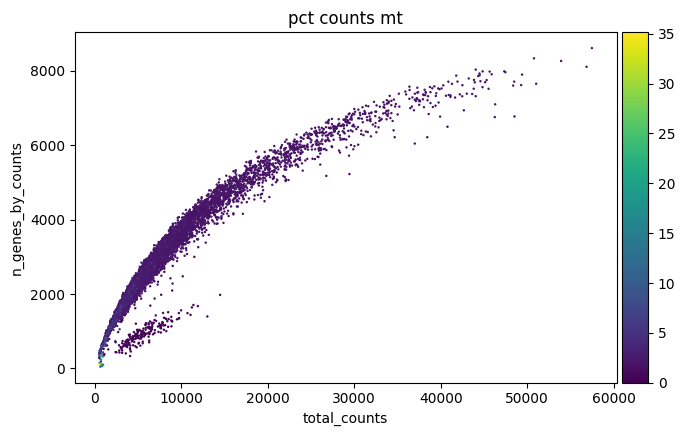

In [ ]:
output_file = "_11.5_plot_beforeFiltering.png"
sc.pl.scatter(
    E11_5_obj,
    "total_counts",
    "n_genes_by_counts",
    color="pct_counts_mt",
    save=output_file)

In [ ]:
# Filter data according to QC metrics

E10_5_obj = E10_5_obj[
    (E10_5_obj.obs["pct_counts_mt"] < 5) &
    (E10_5_obj.obs["n_genes_by_counts"] < 6000) &
    (E10_5_obj.obs["n_genes_by_counts"] > 200)
]

E11_5_obj = E11_5_obj[
    (E11_5_obj.obs["pct_counts_mt"] < 5) &
    (E11_5_obj.obs["n_genes_by_counts"] < 6000) &
    (E11_5_obj.obs["n_genes_by_counts"] > 200)
]

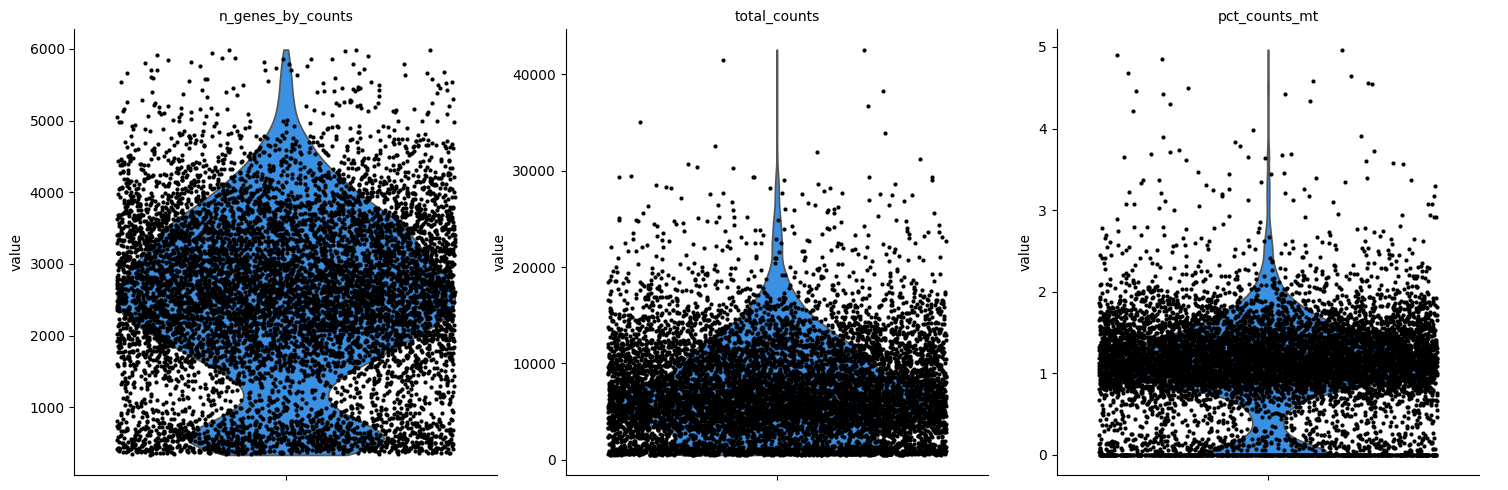

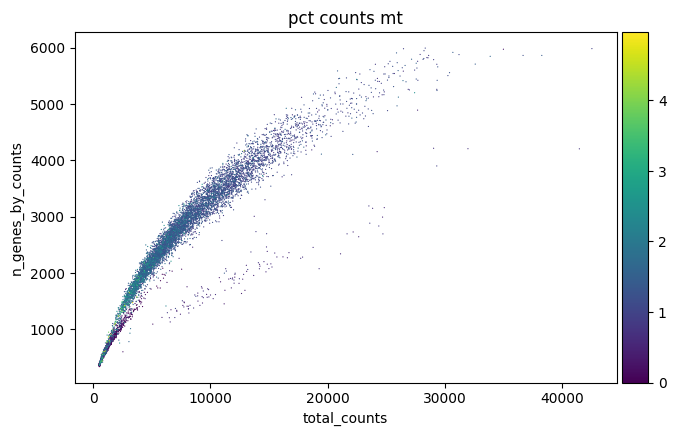

In [ ]:
# Generate violin a scatter plot after filtering

# Violin plot
output_file = "_10.5_plot_afterFiltering.png"
sc.pl.violin(
    E10_5_obj,
    ["n_genes_by_counts", "total_counts", "pct_counts_mt"],
    jitter=0.4,
    color="dodgerblue",
    size=3,
    multi_panel=True,
    save=output_file

)


# Scatter plot
output_file = "_10.5_plot_afterFiltering.png"
sc.pl.scatter(
    E10_5_obj,
    "total_counts",
    "n_genes_by_counts",
    color="pct_counts_mt",
    color_map="viridis",
    size=3,
    save=output_file)

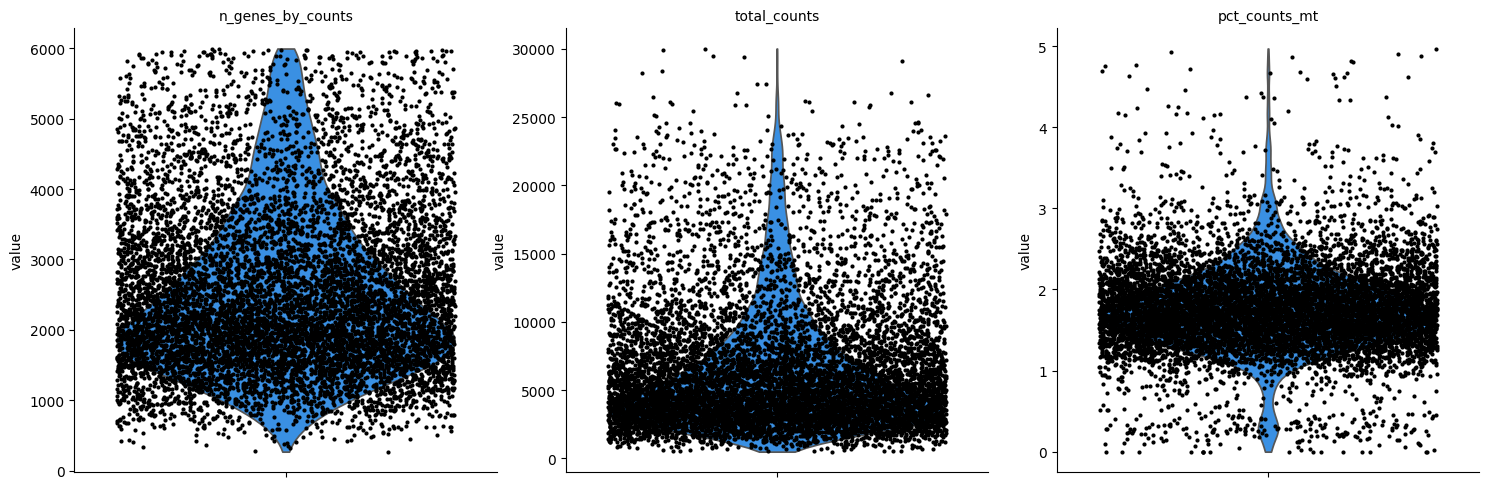

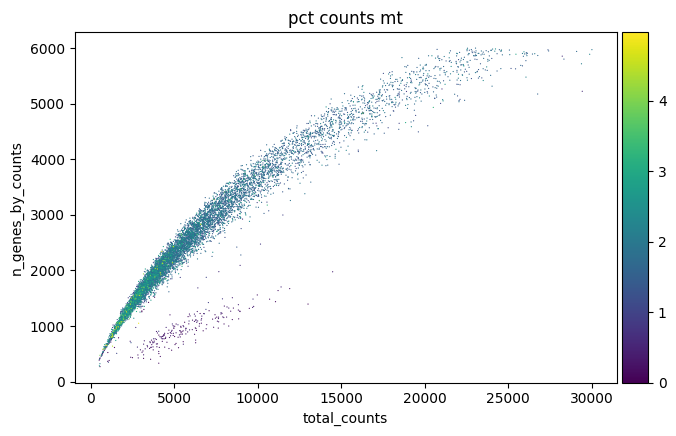

In [ ]:
# Generate violin a scatter plot after filtering

# Violin plot
output_file = "_11.5_plot_afterFiltering.png"
sc.pl.violin(
    E11_5_obj,
    ["n_genes_by_counts", "total_counts", "pct_counts_mt"],
    jitter=0.4,
    color="dodgerblue",
    size=3,
    multi_panel=True,
    save=output_file

)

# Scatter plot
output_file = "_11.5_plot_afterFiltering.png"
sc.pl.scatter(
    E11_5_obj,
    "total_counts",
    "n_genes_by_counts",
    color="pct_counts_mt",
    color_map="viridis",
    size=3,
    save=output_file)


In [ ]:
# Detect doublets
# Doublet detection using Scrublet
E10_5_obj.layers["counts"] = E10_5_obj.X.copy()  # Save count data before normalization

# If the data is in sparse format, convert it to a dense matrix
counts_matrix = E10_5_obj.X.toarray() if scipy.sparse.issparse(E10_5_obj.X) else E10_5_obj.X

# Initialize Scrublet
scrub = scr.Scrublet(counts_matrix)

# Run Scrublet
e10_5_doublet_scores, e10_5_predicted_doublets = scrub.scrub_doublets()

Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.77
Detected doublet rate = 0.0%
Estimated detectable doublet fraction = 1.2%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 0.0%
Elapsed time: 17.5 seconds


In [ ]:
# Detect doublets for E11.5
# Doublet detection using Scrublet
E11_5_obj.layers["counts"] = E11_5_obj.X.copy()  # Save count data before normalization

# If the data is in sparse format, convert it to a dense matrix
counts_matrix = E11_5_obj.X.toarray() if scipy.sparse.issparse(E11_5_obj.X) else E11_5_obj.X

# Initialize Scrublet
scrub = scr.Scrublet(counts_matrix)

# Run Scrublet
e11_5_doublet_scores, e11_5_predicted_doublets = scrub.scrub_doublets()

Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.62
Detected doublet rate = 0.1%
Estimated detectable doublet fraction = 2.4%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 4.5%
Elapsed time: 15.9 seconds


(<Figure size 800x300 with 2 Axes>,
 array([<Axes: title={'center': 'Observed transcriptomes'}, xlabel='Doublet score', ylabel='Prob. density'>,
        <Axes: title={'center': 'Simulated doublets'}, xlabel='Doublet score', ylabel='Prob. density'>],
       dtype=object))

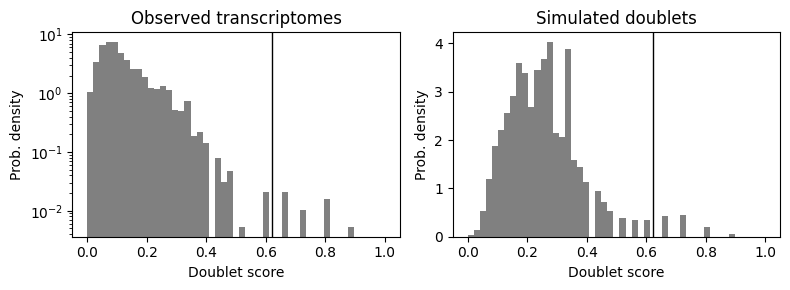

In [ ]:
# Plot doublets results for E10.5
# Add the results back to the AnnData object
E10_5_obj.obs["e10_5_doublet_scores"] = e10_5_doublet_scores
E10_5_obj.obs["e10_5_predicted_doublets"] = e10_5_predicted_doublets.astype(str)  # Ensure boolean values are converted to strings for visualization

E10_5_obj = E10_5_obj[E10_5_obj.obs["e10_5_predicted_doublets"] == "False", :]

# Save a histogram of doublet scores
scrub.plot_histogram()

(<Figure size 800x300 with 2 Axes>,
 array([<Axes: title={'center': 'Observed transcriptomes'}, xlabel='Doublet score', ylabel='Prob. density'>,
        <Axes: title={'center': 'Simulated doublets'}, xlabel='Doublet score', ylabel='Prob. density'>],
       dtype=object))

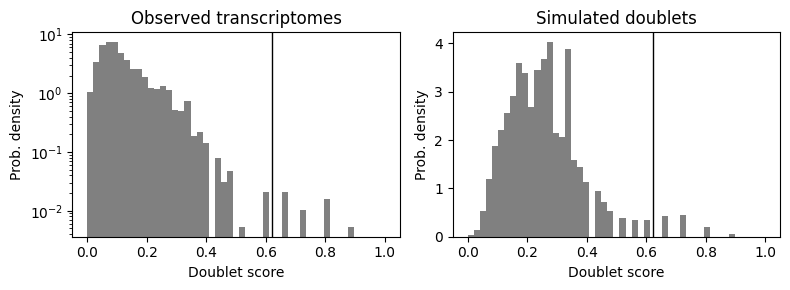

In [ ]:
# Plot doublets results for E11.5
# Add the results back to the AnnData object
E11_5_obj.obs["e11_5_doublet_scores"] = e11_5_doublet_scores
E11_5_obj.obs["e11_5_predicted_doublets"] = e11_5_predicted_doublets.astype(str)  # Ensure boolean values are converted to strings for visualization

E11_5_obj = E11_5_obj[E11_5_obj.obs["e11_5_predicted_doublets"] == "False", :]

# Save a histogram of doublet scores
scrub.plot_histogram()

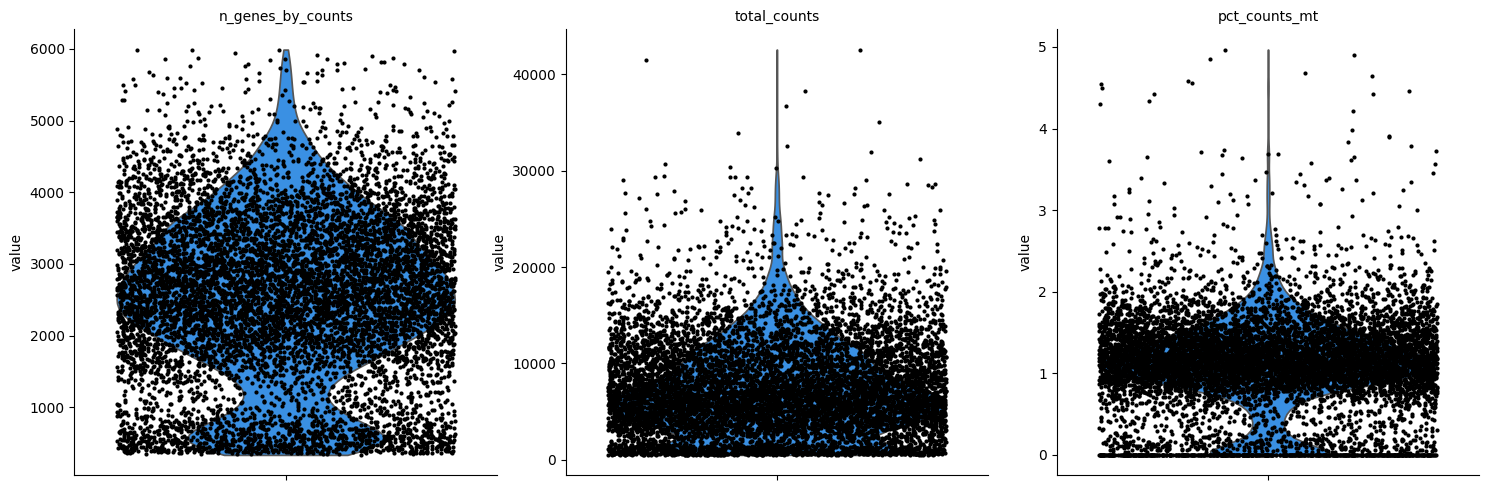

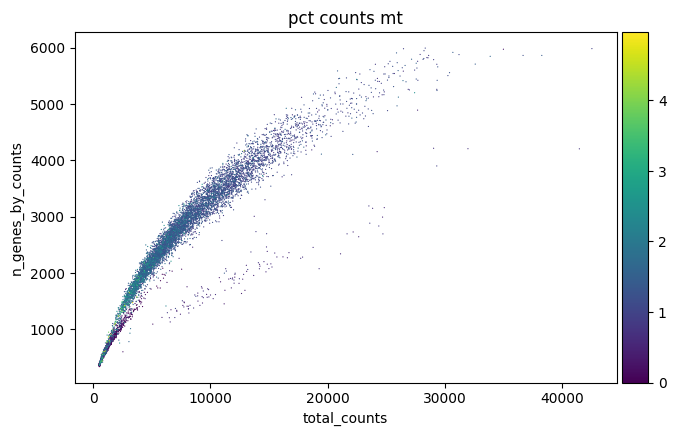

In [ ]:
# Make violin plots after doublets removal

# Generate violin a scatter plot after filtering

# Violin plot
output_file = "_10.5_plot_afterFiltering.png"
sc.pl.violin(
    E10_5_obj,
    ["n_genes_by_counts", "total_counts", "pct_counts_mt"],
    jitter=0.4,
    color="dodgerblue",
    size=3,
    multi_panel=True,
    save=output_file

)

# Scatter plot
output_file = "_10.5_plot_afterFiltering.png"
sc.pl.scatter(
    E10_5_obj,
    "total_counts",
    "n_genes_by_counts",
    color="pct_counts_mt",
    color_map="viridis",
    size=3,
    save=output_file)

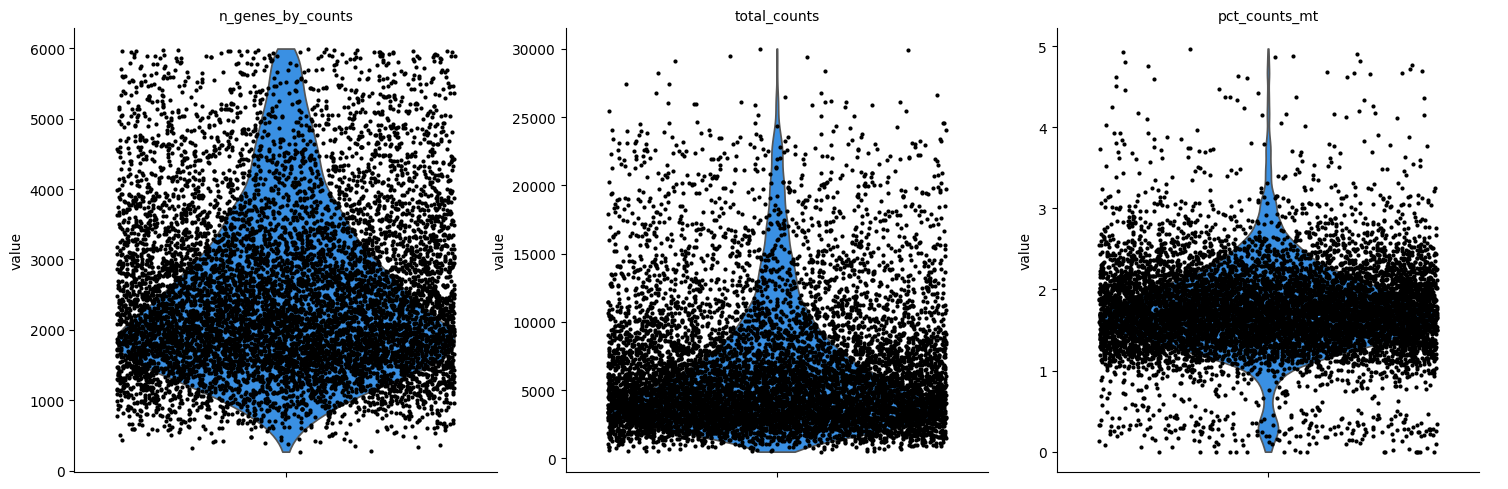

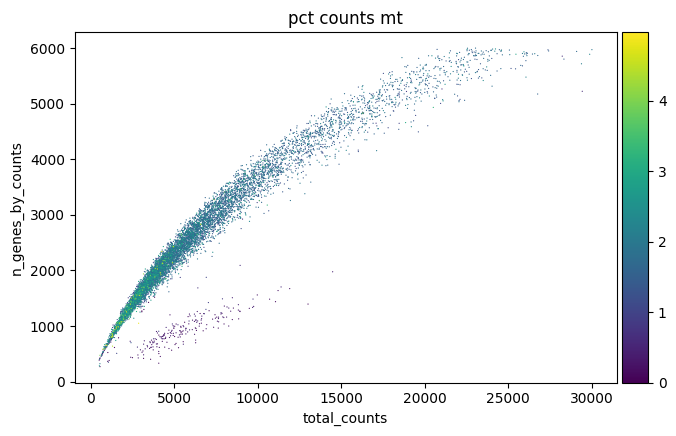

In [ ]:
# Generate violin a scatter plot after filtering

# Violin plot
output_file = "_11.5_plot_afterFiltering.png"
sc.pl.violin(
    E11_5_obj,
    ["n_genes_by_counts", "total_counts", "pct_counts_mt"],
    jitter=0.4,
    color="dodgerblue",
    size=3,
    multi_panel=True,
    save=output_file

)

# Scatter plot
output_file = "_11.5_plot_afterFiltering.png"
sc.pl.scatter(
    E11_5_obj,
    "total_counts",
    "n_genes_by_counts",
    color="pct_counts_mt",
    color_map="viridis",
    size=3,
    save=output_file)

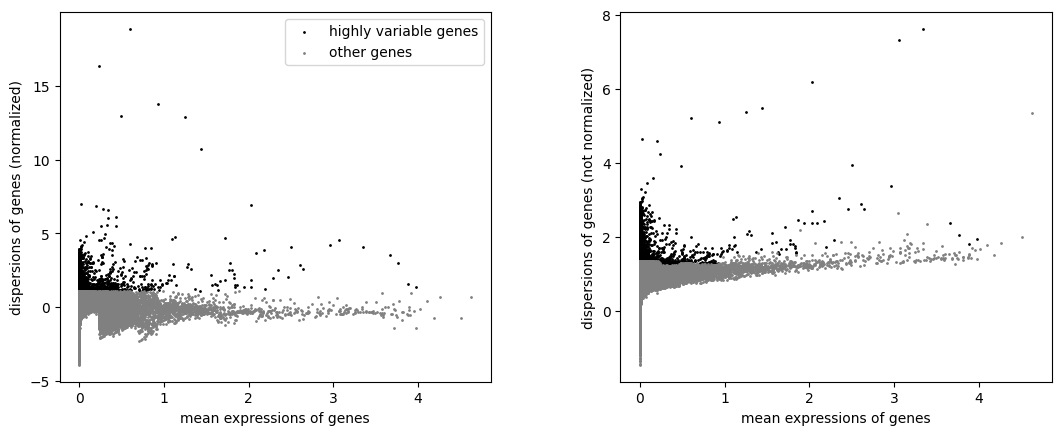

In [ ]:
# Preserve raw data for DE analysis
E10_5_obj.raw = E10_5_obj.copy()

# Normalizing to median total counts
sc.pp.normalize_total(E10_5_obj, target_sum=1e4)

# Logarithmize the data
sc.pp.log1p(E10_5_obj)

# Feature selection (highly variable genes)
sc.pp.highly_variable_genes(E10_5_obj, n_top_genes=2000)
sc.pl.highly_variable_genes(E10_5_obj)

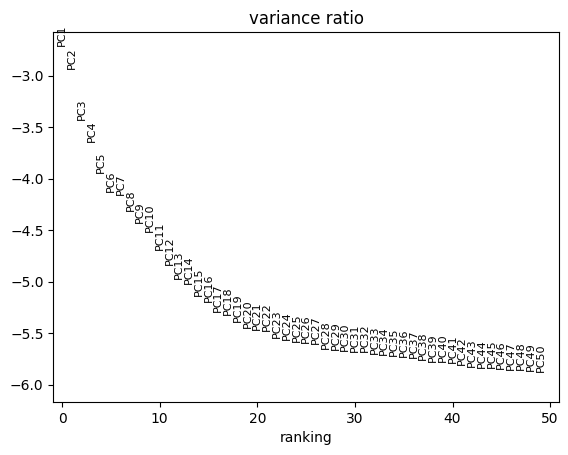

In [ ]:
# Run PCA
sc.tl.pca(E10_5_obj)
# Elbow plot
output_file = "_E10.5_elbow_plot.png"
sc.pl.pca_variance_ratio(
    E10_5_obj,
    n_pcs=50,
    log=True,
    save=output_file)

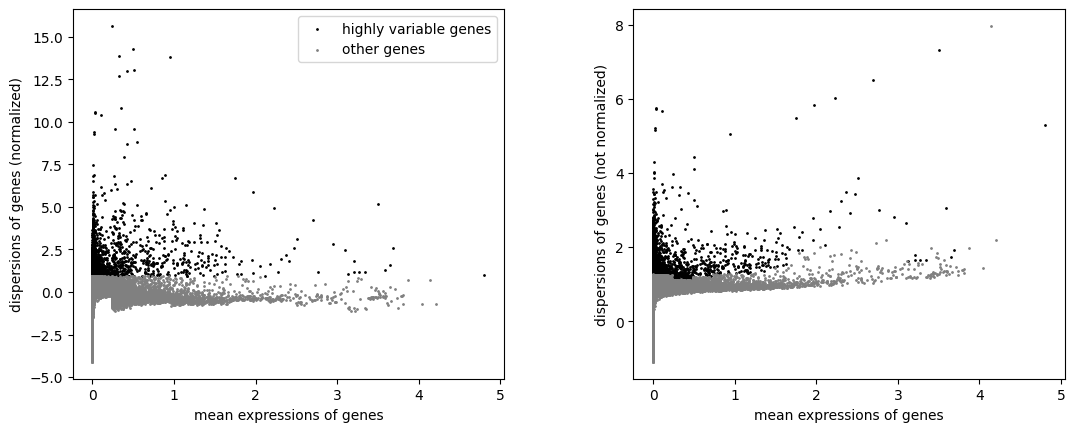

In [ ]:
# Preserve raw data for DE analysis
E11_5_obj.raw = E11_5_obj.copy()

# Normalizing to median total counts
sc.pp.normalize_total(E11_5_obj, target_sum=1e4)

# Logarithmize the data
sc.pp.log1p(E11_5_obj)

# Feature selection (highly variable genes)
sc.pp.highly_variable_genes(E11_5_obj, n_top_genes=2000)
sc.pl.highly_variable_genes(E11_5_obj)

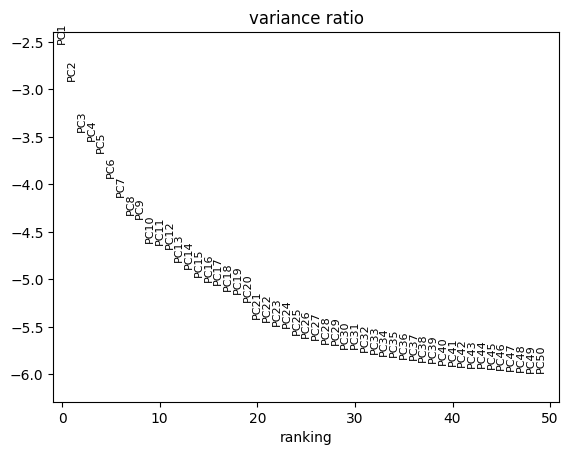

In [ ]:
# Run PCA
sc.tl.pca(E11_5_obj)
# Elbow plot
output_file = "_E11.5_elbow_plot.png"
sc.pl.pca_variance_ratio(
    E11_5_obj,
    n_pcs=50,
    log=True,
    save=output_file)

In [ ]:
# Neirest neighbor graph construction and visualization
# Construct neighbors graph using PCA representation of data
# E10_5_obj
sc.pp.neighbors(E10_5_obj)

# Embed the graph into UMAP
sc.tl.umap(E10_5_obj)

# E11_5_obj
sc.pp.neighbors(E11_5_obj)

# Embed the graph into UMAP
sc.tl.umap(E11_5_obj)

In [ ]:
!pip install leidenalg
!pip install scikit-misc

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 189.0/189.0 kB 4.8 MB/s eta 0:00:00


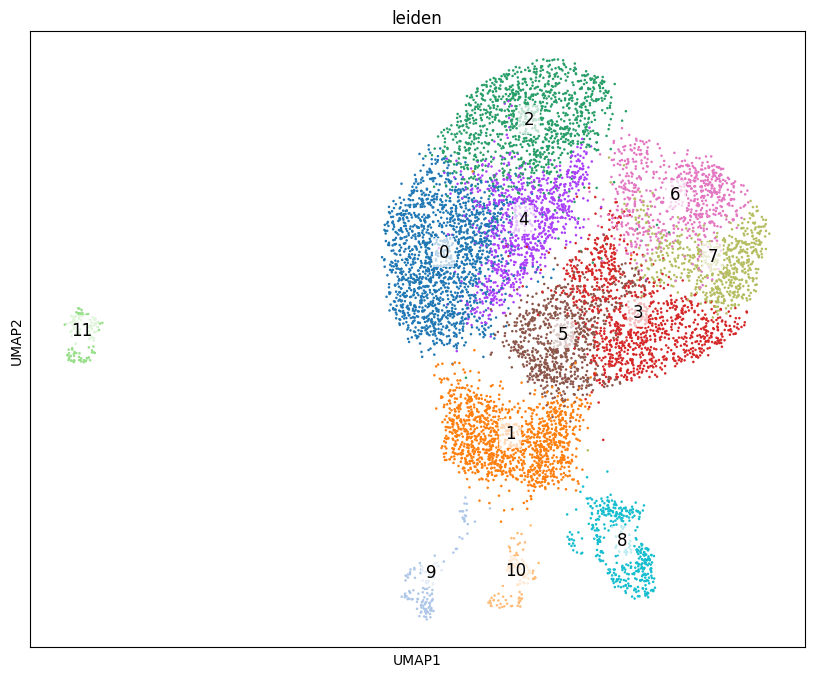

In [ ]:
# Clustering E10.5
# As with Seurat and many other frameworks, we recommend the Leiden graph-clustering
# method (community detection based on optimizing modularity) [Traag et al., 2019].
# Note that Leiden clustering directly clusters the neighborhood graph of cells, which
# we already computed in the previous section.

# Perform Leiden clustering
sc.tl.leiden(E10_5_obj, resolution=0.8, n_iterations=2)

# Overlay cluster labels
fig, ax = plt.subplots(figsize=(10, 8))
sc.pl.umap(
    E10_5_obj,
    color=["leiden"],
    ax=ax,
    legend_loc=None,
    show=False  # Prevents automatic display
)

# Add text labels for each cluster
for cluster in E10_5_obj.obs['leiden'].cat.categories:  # Use E10_5_obj here
    # Compute the median position of each cluster
    cluster_mask = E10_5_obj.obs['leiden'] == cluster  # Use E10_5_obj here
    x = E10_5_obj.obsm['X_umap'][cluster_mask, 0].mean()
    y = E10_5_obj.obsm['X_umap'][cluster_mask, 1].mean()
    ax.text(
        x,
        y,
        cluster,
        color="black",
        fontsize=12,
        ha="center",
        bbox=dict(facecolor='white', alpha=0.7, edgecolor='none')
    )

# Save the labeled plot
# Define the output file name
output_file = "E10.5_UMAP_afterClustering_plot_res0.8_labeled.png"

plt.savefig(output_file, dpi=300)
plt.show()

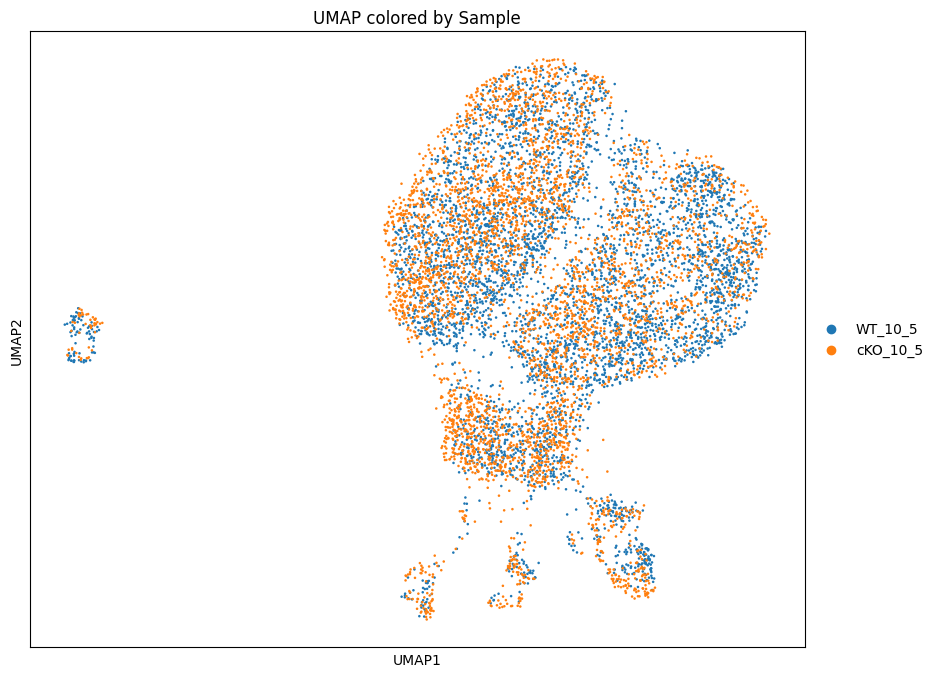

In [ ]:
# Perform Leiden clustering
sc.tl.leiden(E10_5_obj, resolution=0.8, n_iterations=2)

# Create a single UMAP plot colored by sample
fig, ax = plt.subplots(figsize=(10, 8))

sc.pl.umap(
    E10_5_obj,
    color=['sample'],  # Color by sample type
    ax=ax,
    legend_loc='right margin',
    title='UMAP colored by Sample',
    show=False
)

# Save the UMAP plot
output_file = "E10.5_UMAP_by_Sample.png"
plt.savefig(output_file, dpi=300, bbox_inches='tight')
plt.show()

Chi-square statistic: 241.79
p-value: 0.000000
Degrees of freedom: 11

Expected frequencies:
leiden             0           1           2          3           4  \
sample                                                                
WT_10_5   871.506923  670.267084  599.460473  576.03573  492.984368   
cKO_10_5  765.493077  588.732916  526.539527  505.96427  433.015632   

leiden             5           6          7           8          9         10  \
sample                                                                          
WT_10_5   432.825368  372.133988  333.80259  214.549352  72.403752  66.547566   
cKO_10_5  380.174632  326.866012  293.19741  188.450648  63.596248  58.452434   

leiden           11  
sample               
WT_10_5   65.482805  
cKO_10_5  57.517195  

Standardized residuals (values > |2| indicate significant contributors):
leiden           0         1         2         3         4         5  \
sample                                                         

<Figure size 1000x600 with 0 Axes>

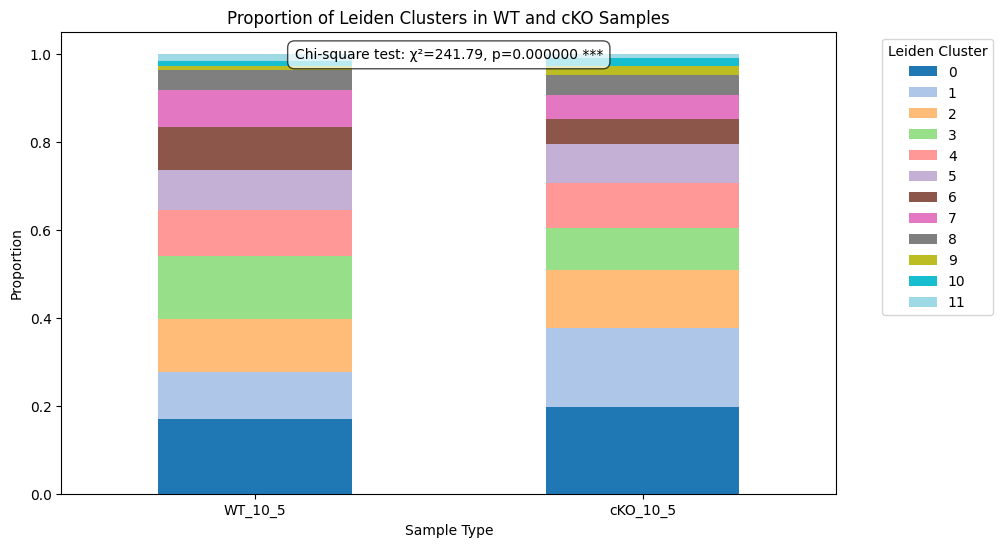

In [ ]:
# Determine proportion of genotypes in each leiden cluster

# Extract Leiden cluster assignments and sample identities
# Use the original counts for statistical testing, not the proportions
cluster_sample_counts = pd.crosstab(E10_5_obj.obs['sample'], E10_5_obj.obs['leiden'])

# Perform chi-square test on the counts
chi2, p_value, dof, expected = stats.chi2_contingency(cluster_sample_counts)

# Print the results
print(f"Chi-square statistic: {chi2:.2f}")
print(f"p-value: {p_value:.6f}")
print(f"Degrees of freedom: {dof}")
print("\nExpected frequencies:")
expected_df = pd.DataFrame(expected,
                          index=cluster_sample_counts.index,
                          columns=cluster_sample_counts.columns)
print(expected_df)

# Identify which specific clusters contribute most to the difference:
# Calculate the standardized residuals
observed = cluster_sample_counts.values
residuals = (observed - expected) / np.sqrt(expected)
residuals_df = pd.DataFrame(residuals,
                           index=cluster_sample_counts.index,
                           columns=cluster_sample_counts.columns)
print("\nStandardized residuals (values > |2| indicate significant contributors):")
print(residuals_df)

# Convert counts to proportions for visualization
cluster_sample_proportions = cluster_sample_counts.div(cluster_sample_counts.sum(axis=1), axis=0)

# Set up the figure
plt.figure(figsize=(10, 6))

# Create stacked bar chart directly from the proportions dataframe
ax = cluster_sample_proportions.plot(kind='bar', stacked=True, figsize=(10, 6), colormap='tab20')

# Add chi-square test results to the plot
significance_text = f"Chi-square test: χ²={chi2:.2f}, p={p_value:.6f}"
if p_value < 0.001:
    significance_text += " ***"
elif p_value < 0.01:
    significance_text += " **"
elif p_value < 0.05:
    significance_text += " *"
else:
    significance_text += " (ns)"

plt.annotate(significance_text, xy=(0.5, 0.95), xycoords='axes fraction',
             ha='center', va='center', fontsize=10,
             bbox=dict(boxstyle='round,pad=0.5', facecolor='white', alpha=0.7))

plt.xlabel('Sample Type')
plt.ylabel('Proportion')
plt.title('Proportion of Leiden Clusters in WT and cKO Samples')
plt.legend(title='Leiden Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=0)  # Make x-axis labels horizontal

# Save the plot
plt.savefig("E10.5_Stacked_Barplot_with_Stats.png", dpi=300, bbox_inches='tight')

plt.show()

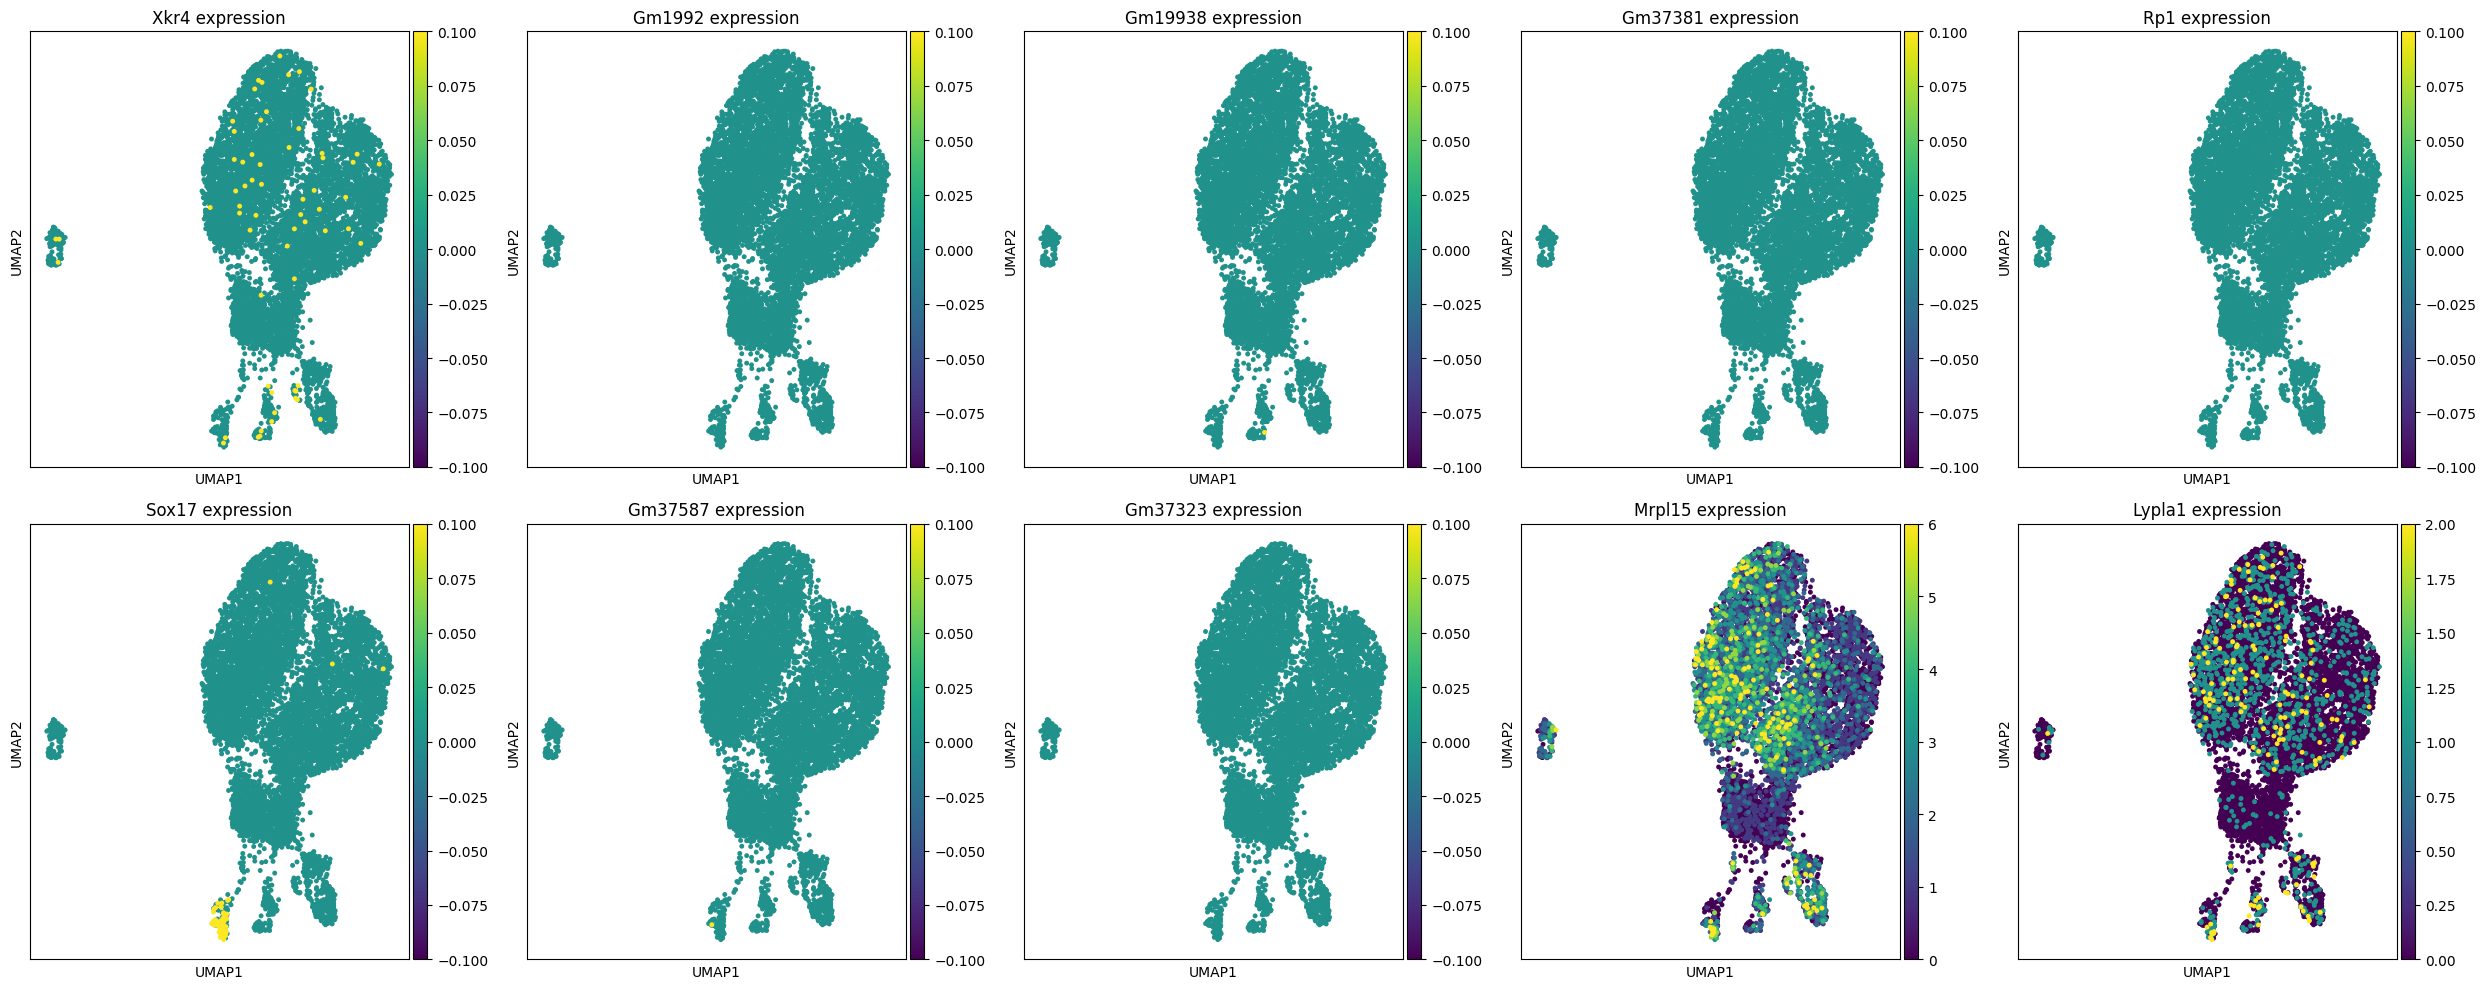

In [ ]:
# Perform Leiden clustering
sc.tl.leiden(E10_5_obj, resolution=0.8, n_iterations=2)

# Define genes to plot
genes_to_plot = ['Xkr4', 'Gm1992', 'Gm19938', 'Gm37381', 'Rp1', 'Sox17', 'Gm37587', 'Gm37323', 'Mrpl15', 'Lypla1']

# Create a 2x5 plot layout
fig, axes = plt.subplots(2, 5, figsize=(25, 10))
axes = axes.flatten()

# Plot each gene
for idx, gene in enumerate(genes_to_plot):
    sc.pl.umap(
        E10_5_obj,
        color=[gene],
        ax=axes[idx],
        title=f'{gene} expression',
        show=False,
        color_map='viridis',  # You can change colormap if needed
        size=50,              # Adjust point size
        vmin=0,              # Start colorscale at 0
        vmax='p99'           # Cap at 99th percentile to handle outliers
    )

# Adjust layout
plt.tight_layout()

# Save the multi-panel plot
output_file = "E10.5_UMAP_gene_expression_plot.png"
plt.savefig(output_file, dpi=300, bbox_inches='tight')
plt.show()

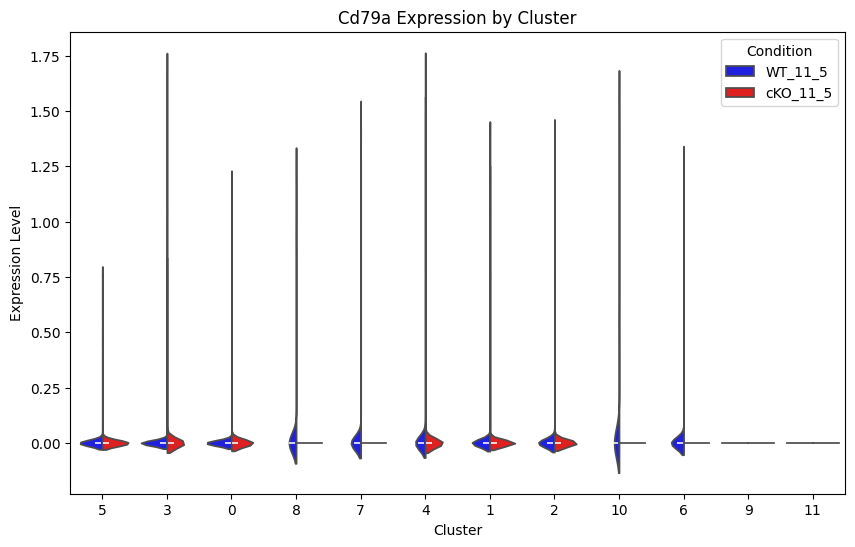

In [ ]:
# Perform Leiden clustering
sc.tl.leiden(E11_5_obj, resolution=0.8, n_iterations=2)

# Define the gene to plot
gene_to_plot = 'Cd79a'  # Change this to the gene you want to analyze

# Define a dynamic palette based on observed conditions
unique_conditions = E11_5_obj.obs['sample'].unique()
palette = {cond: col for cond, col in zip(unique_conditions, ['blue', 'red'])}

# Prepare data for violin plot
if gene_to_plot in E11_5_obj.var_names:
    df = pd.DataFrame({
        'Expression': E11_5_obj[:, gene_to_plot].X.toarray().flatten(),  # Convert sparse matrix to dense
        'Cluster': E11_5_obj.obs['leiden'].astype(str),
        'Condition': E11_5_obj.obs['sample']
    })

    plt.figure(figsize=(10, 6))
    sns.violinplot(
        data=df,
        x='Cluster',
        y='Expression',
        hue='Condition',
        split=True,
        palette=palette
    )
    plt.title(f'{gene_to_plot} Expression by Cluster')
    plt.xlabel('Cluster')
    plt.ylabel('Expression Level')
    plt.legend(title='Condition')

    # Save the plot
    output_file = f"E10.5_Violin_{gene_to_plot}_expression_plot.png"
    plt.savefig(output_file, dpi=300, bbox_inches='tight')
    plt.show()


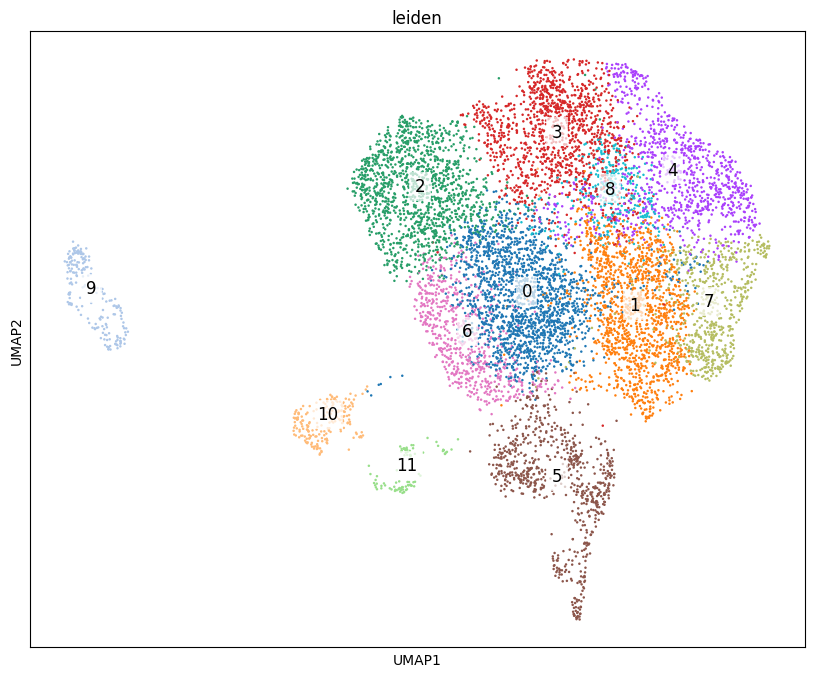

In [ ]:
# Clustering E11.5
# As with Seurat and many other frameworks, we recommend the Leiden graph-clustering
# method (community detection based on optimizing modularity) [Traag et al., 2019].
# Note that Leiden clustering directly clusters the neighborhood graph of cells, which
# we already computed in the previous section.

# Perform Leiden clustering
sc.tl.leiden(E11_5_obj, resolution=0.8, n_iterations=2)



# Overlay cluster labels
fig, ax = plt.subplots(figsize=(10, 8))
sc.pl.umap(
    E11_5_obj,
    color=["leiden"],
    ax=ax,
    legend_loc=None,
    show=False  # Prevents automatic display
)

# Add text labels for each cluster
for cluster in E11_5_obj.obs['leiden'].cat.categories:  # Use E10_5_obj here
    # Compute the median position of each cluster
    cluster_mask = E11_5_obj.obs['leiden'] == cluster  # Use E10_5_obj here
    x = E11_5_obj.obsm['X_umap'][cluster_mask, 0].mean()
    y = E11_5_obj.obsm['X_umap'][cluster_mask, 1].mean()
    ax.text(
        x,
        y,
        cluster,
        color="black",
        fontsize=12,
        ha="center",
        bbox=dict(facecolor='white', alpha=0.7, edgecolor='none')
    )

# Save the labeled plot
# Define the output file name
output_file = "E11.5_UMAP_afterClustering_plot_res0.8_labeled.png"
plt.savefig(output_file, dpi=300)
plt.show()

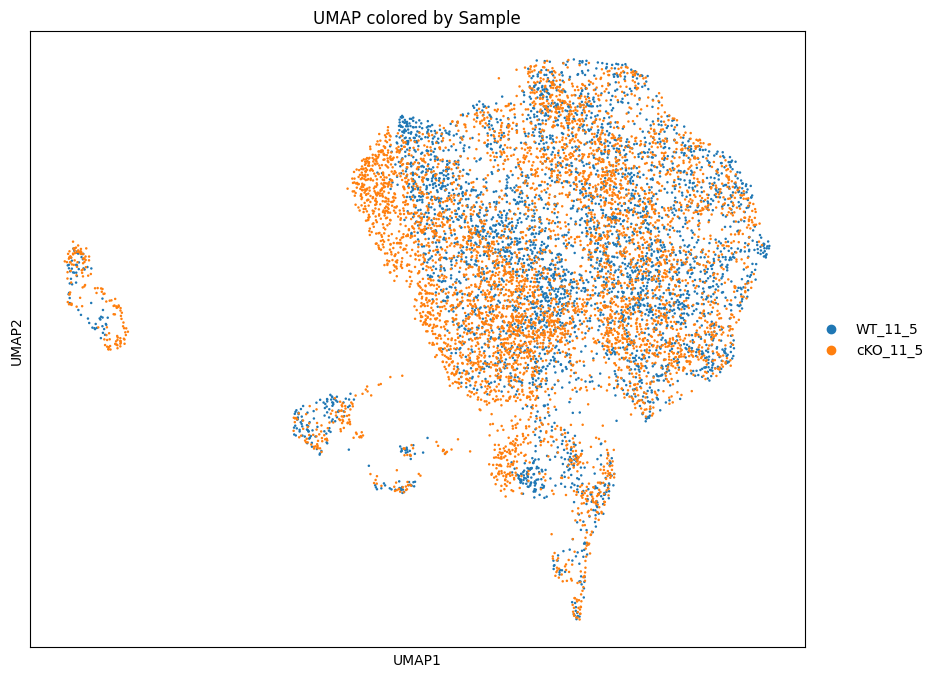

In [ ]:
# Perform Leiden clustering
sc.tl.leiden(E11_5_obj, resolution=0.8, n_iterations=2)

# Create a single UMAP plot colored by sample
fig, ax = plt.subplots(figsize=(10, 8))

sc.pl.umap(
    E11_5_obj,
    color=['sample'],  # Color by sample type
    ax=ax,
    legend_loc='right margin',
    title='UMAP colored by Sample',
    show=False
)

# Save the UMAP plot
output_file = "E11.5_UMAP_by_Sample.png"
plt.savefig(output_file, dpi=300, bbox_inches='tight')
plt.show()

Chi-square statistic: 100.91
p-value: 0.000000
Degrees of freedom: 11

Expected frequencies:
leiden              0           1           2           3           4  \
sample                                                                  
WT_11_5    750.329038  581.228836  563.384091  519.621978  401.931637   
cKO_11_5  1015.670962  786.771164  762.615909  703.378022  544.068363   

leiden             5           6          7          8           9  \
sample                                                               
WT_11_5   299.111916  279.567671  248.12693  142.75796   84.125226   
cKO_11_5  404.888084  378.432329  335.87307  193.24204  113.874774   

leiden            10         11  
sample                           
WT_11_5    82.850602  36.964115  
cKO_11_5  112.149398  50.035885  

Standardized residuals (values > |2| indicate significant contributors):
leiden           0         1         2         3         4         5  \
sample                                             

<Figure size 1000x600 with 0 Axes>

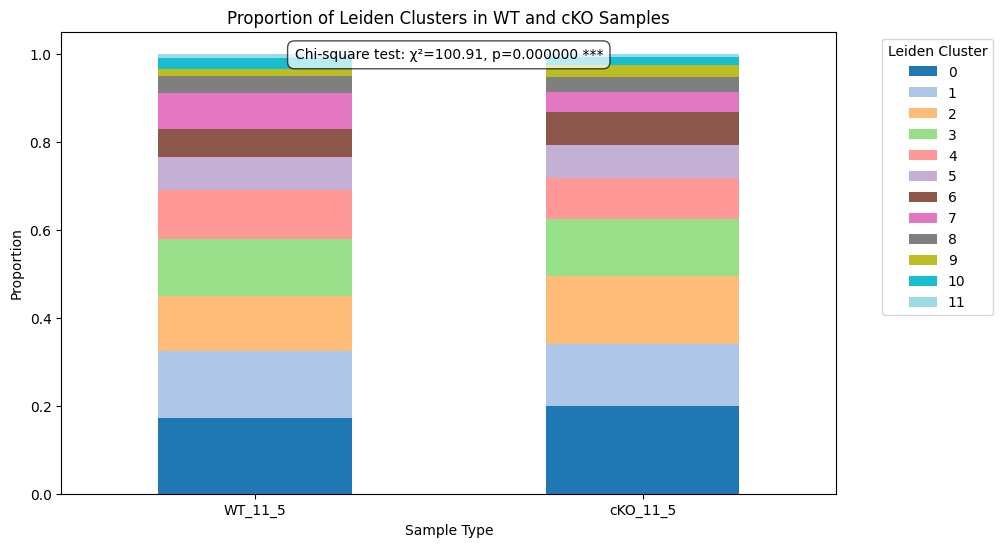

In [ ]:
# Determine proportion of genotypes in each leiden cluster E11_5

# Extract Leiden cluster assignments and sample identities
# Use the original counts for statistical testing, not the proportions
cluster_sample_counts = pd.crosstab(E11_5_obj.obs['sample'], E11_5_obj.obs['leiden'])

# Perform chi-square test on the counts
chi2, p_value, dof, expected = stats.chi2_contingency(cluster_sample_counts)

# Print the results
print(f"Chi-square statistic: {chi2:.2f}")
print(f"p-value: {p_value:.6f}")
print(f"Degrees of freedom: {dof}")
print("\nExpected frequencies:")
expected_df = pd.DataFrame(expected,
                          index=cluster_sample_counts.index,
                          columns=cluster_sample_counts.columns)
print(expected_df)

# Identify which specific clusters contribute most to the difference:
# Calculate the standardized residuals
observed = cluster_sample_counts.values
residuals = (observed - expected) / np.sqrt(expected)
residuals_df = pd.DataFrame(residuals,
                           index=cluster_sample_counts.index,
                           columns=cluster_sample_counts.columns)
print("\nStandardized residuals (values > |2| indicate significant contributors):")
print(residuals_df)

# Convert counts to proportions for visualization
cluster_sample_proportions = cluster_sample_counts.div(cluster_sample_counts.sum(axis=1), axis=0)

# Set up the figure
plt.figure(figsize=(10, 6))

# Create stacked bar chart directly from the proportions dataframe
ax = cluster_sample_proportions.plot(kind='bar', stacked=True, figsize=(10, 6), colormap='tab20')

# Add chi-square test results to the plot
significance_text = f"Chi-square test: χ²={chi2:.2f}, p={p_value:.6f}"
if p_value < 0.001:
    significance_text += " ***"
elif p_value < 0.01:
    significance_text += " **"
elif p_value < 0.05:
    significance_text += " *"
else:
    significance_text += " (ns)"

plt.annotate(significance_text, xy=(0.5, 0.95), xycoords='axes fraction',
             ha='center', va='center', fontsize=10,
             bbox=dict(boxstyle='round,pad=0.5', facecolor='white', alpha=0.7))

plt.xlabel('Sample Type')
plt.ylabel('Proportion')
plt.title('Proportion of Leiden Clusters in WT and cKO Samples')
plt.legend(title='Leiden Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=0)  # Make x-axis labels horizontal

# Save the plot
plt.savefig("E10.5_Stacked_Barplot_with_Stats.png", dpi=300, bbox_inches='tight')

plt.show()

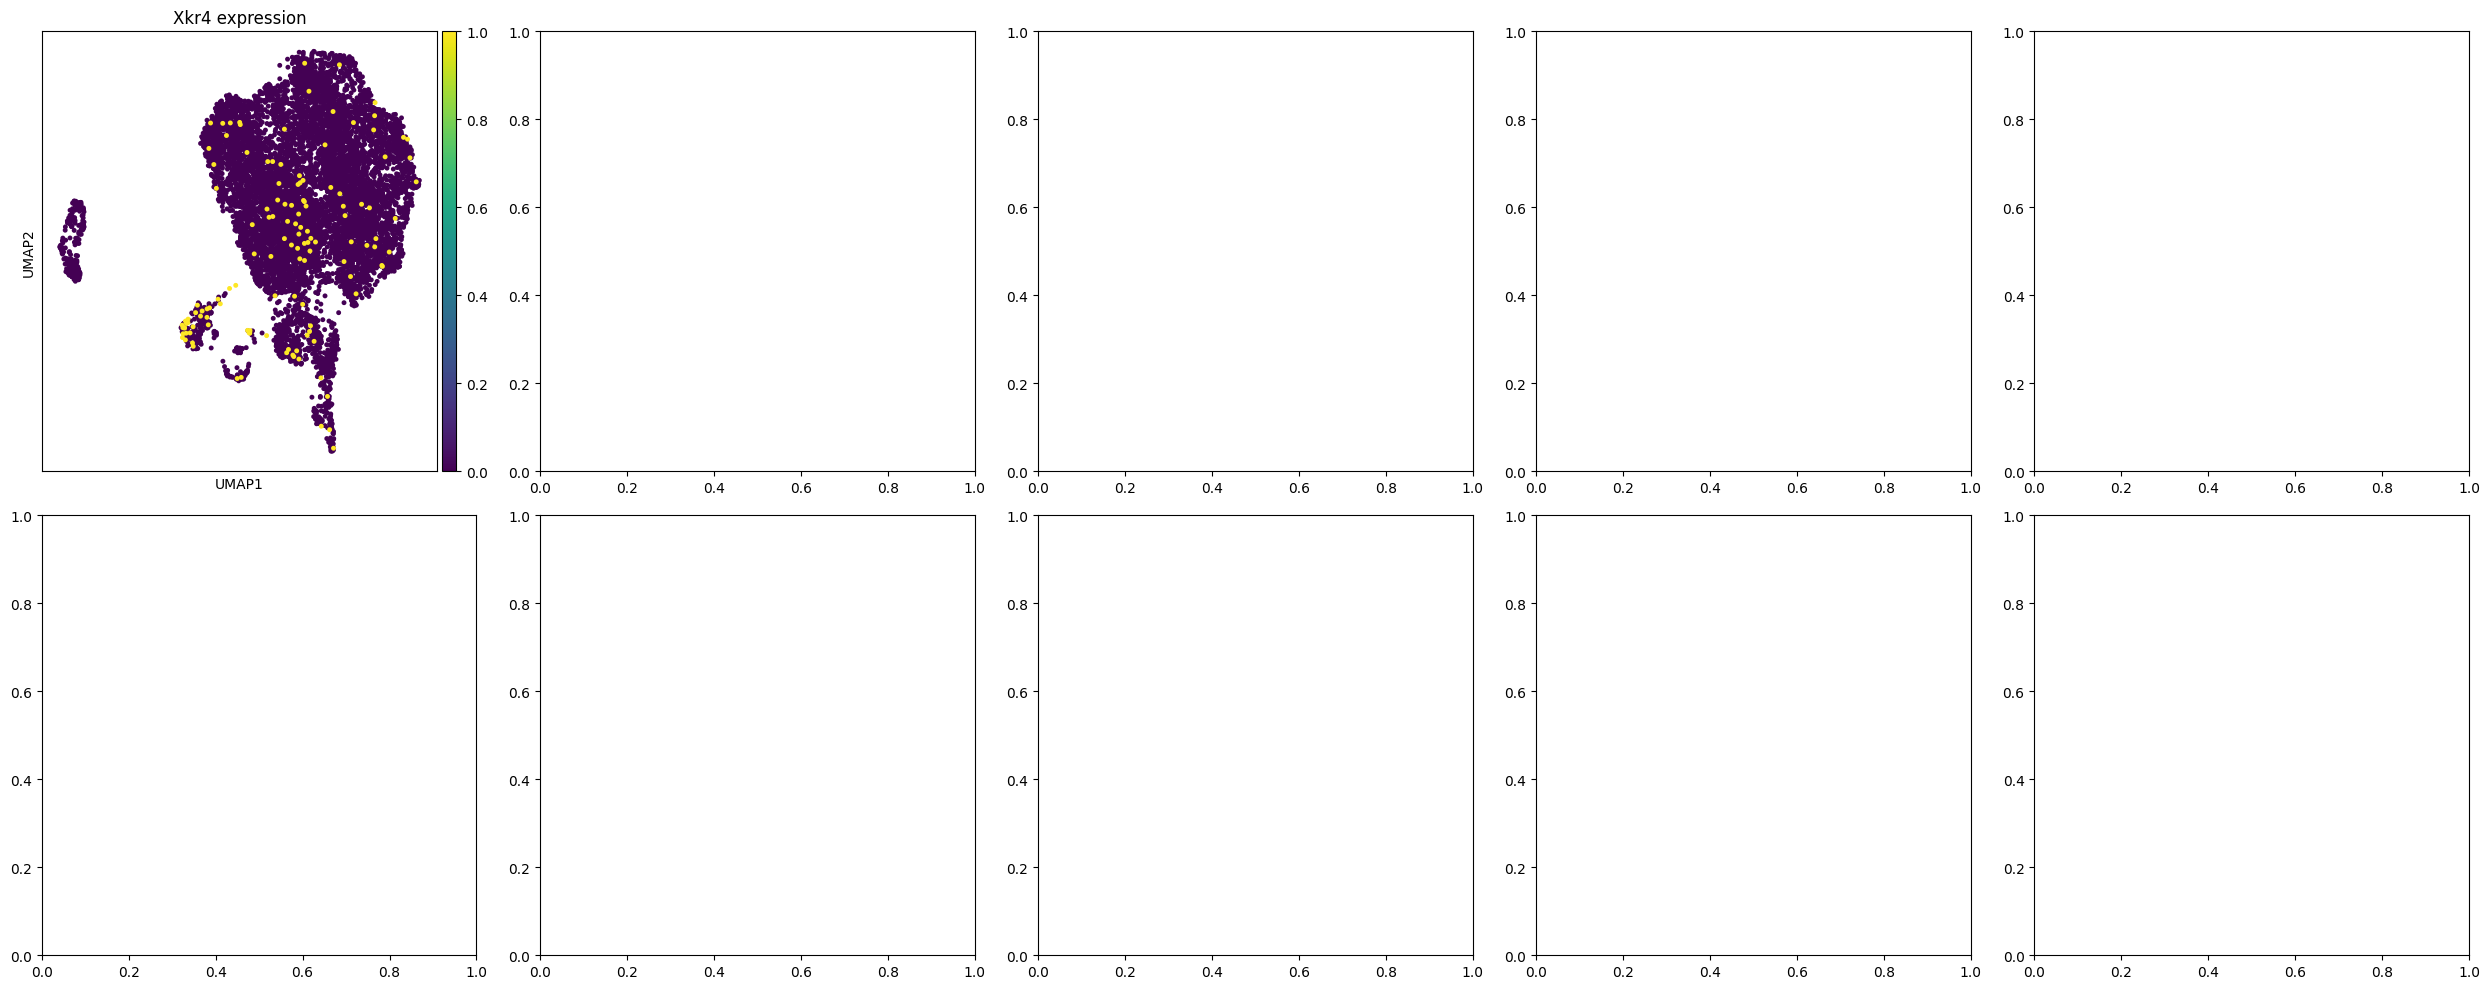

In [ ]:
# Perform Leiden clustering
sc.tl.leiden(E11_5_obj, resolution=0.8, n_iterations=2)

# Define genes to plot
#genes_to_plot = ['Xkr4', 'Gm1992', 'Gm19938', 'Gm37381', 'Rp1', 'Sox17', 'Gm37587', 'Gm37323', 'Mrpl15', 'Lypla1']
genes_to_plot = ['Xkr4']

# Create a 2x5 plot layout
fig, axes = plt.subplots(2, 5, figsize=(25, 10))
axes = axes.flatten()

# Plot each gene
for idx, gene in enumerate(genes_to_plot):
    sc.pl.umap(
        E11_5_obj,
        color=[gene],
        ax=axes[idx],
        title=f'{gene} expression',
        show=False,
        color_map='viridis',  # You can change colormap if needed
        size=50,              # Adjust point size
        vmin=0,              # Start colorscale at 0
        vmax='p99'           # Cap at 99th percentile to handle outliers
    )

# Adjust layout
plt.tight_layout()

# Save the multi-panel plot
output_file = "E11.5_UMAP_gene_expression_plot.png"
plt.savefig(output_file, dpi=300, bbox_inches='tight')
plt.show()


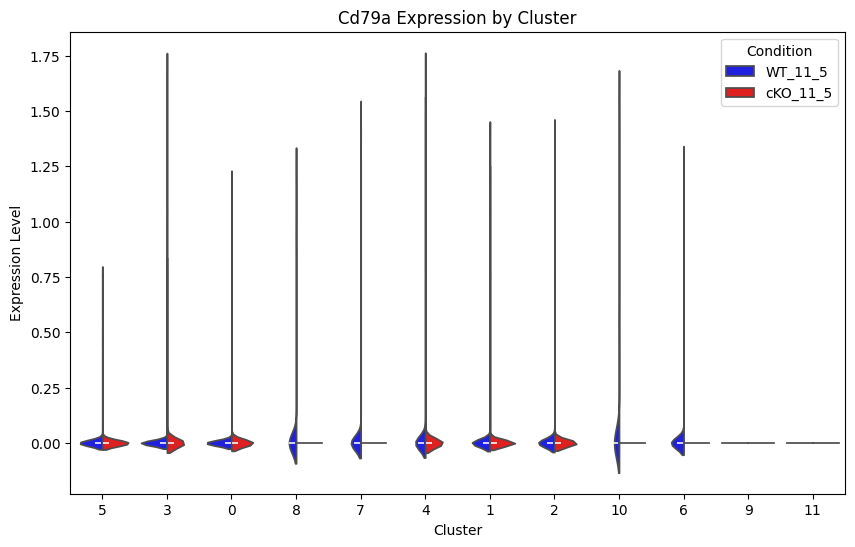

In [ ]:
# Perform Leiden clustering
sc.tl.leiden(E11_5_obj, resolution=0.8, n_iterations=2)

# Define the gene to plot
gene_to_plot = 'Cd79a'  # Change this to the gene you want to analyze

# Define a dynamic palette based on observed conditions
unique_conditions = E11_5_obj.obs['sample'].unique()
palette = {cond: col for cond, col in zip(unique_conditions, ['blue', 'red'])}

# Prepare data for violin plot
if gene_to_plot in E11_5_obj.var_names:
    df = pd.DataFrame({
        'Expression': E11_5_obj[:, gene_to_plot].X.toarray().flatten(),  # Convert sparse matrix to dense
        'Cluster': E11_5_obj.obs['leiden'].astype(str),
        'Condition': E11_5_obj.obs['sample']
    })

    plt.figure(figsize=(10, 6))
    sns.violinplot(
        data=df,
        x='Cluster',
        y='Expression',
        hue='Condition',
        split=True,
        palette=palette
    )
    plt.title(f'{gene_to_plot} Expression by Cluster')
    plt.xlabel('Cluster')
    plt.ylabel('Expression Level')
    plt.legend(title='Condition')

    # Save the plot
    output_file = f"E11.5_Violin_{gene_to_plot}_expression_plot.png"
    plt.savefig(output_file, dpi=300, bbox_inches='tight')
    plt.show()

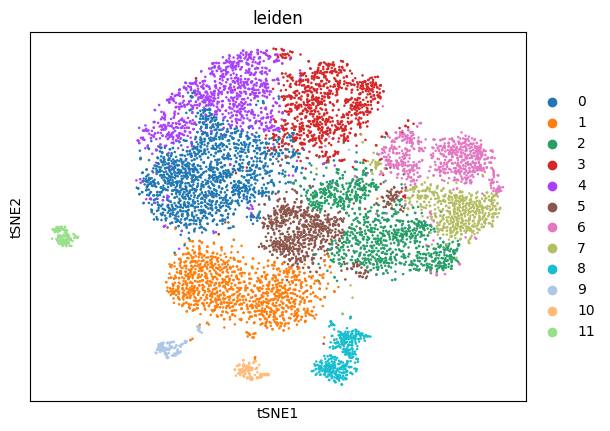

In [ ]:
# Compute t-SNE
sc.tl.tsne(E10_5_obj, perplexity=30.0)

# Run Leiden clustering (same as your original code)
sc.tl.leiden(E10_5_obj, resolution=0.8, n_iterations=2)

# Plot t-SNE instead of UMAP
output_file = "_E10.5_tSNE_afterClustering_plot_res0.8_perp30.png"
sc.pl.tsne(
    E10_5_obj,
    color=["leiden"],
    save=output_file,
)

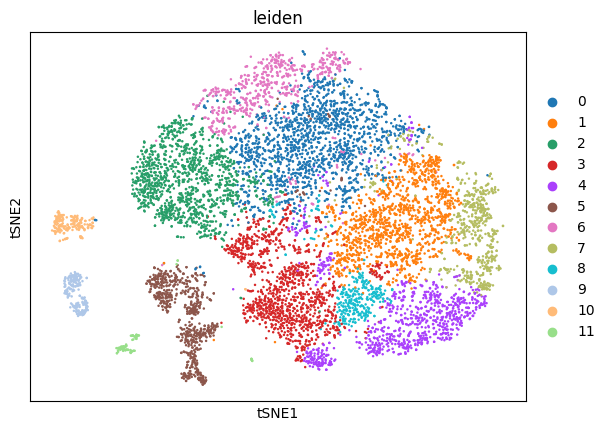

In [ ]:
# Compute t-SNE
sc.tl.tsne(E11_5_obj, perplexity=30.0)

# Run Leiden clustering (same as your original code)
sc.tl.leiden(E11_5_obj, resolution=0.8, n_iterations=2)

# Plot t-SNE instead of UMAP
output_file = "_E11.5_tSNE_afterClustering_plot_res0.8_perp30.png"
sc.pl.tsne(
    E11_5_obj,
    color=["leiden"],
    save=output_file,
)

In [ ]:
# DE E10.5
# Perform markers identification for E10.5

sc.tl.rank_genes_groups(
    E10_5_obj,  # Replace with your AnnData object
    groupby='leiden',  # Column in `.obs` with cluster labels
    method='wilcoxon',  # Differential expression method ('t-test', 'wilcoxon', etc.)
    n_genes=30  # Number of DE genes to compute (can adjust as needed)
)

# Extract the top 10 marker genes per cluster
markers = sc.get.rank_genes_groups_df(E10_5_obj, group=None)
print(markers)

# Save markers to a file
markers.to_csv("E10.5_top_30_markers_per_cluster.csv", index=False)

    group      names     scores  logfoldchanges         pvals     pvals_adj
0       0       Nnat  44.052589       14.015818  0.000000e+00  0.000000e+00
1       0  Hist1h2ap  41.982178        6.859735  0.000000e+00  0.000000e+00
2       0      Cped1  41.424149        4.363638  0.000000e+00  0.000000e+00
3       0   Hist1h1b  40.974392       17.721880  0.000000e+00  0.000000e+00
4       0   Hist1h1e  40.496071        9.899164  0.000000e+00  0.000000e+00
..    ...        ...        ...             ...           ...           ...
355    11        Rhd  17.791090       11.574619  8.285171e-71  1.028795e-67
356    11       Cpox  17.737347       10.035752  2.158950e-70  2.581545e-67
357    11      Creg1  17.682108        9.151583  5.760111e-70  6.641614e-67
358    11      Prdx2  17.629101       65.819962  1.472897e-69  1.639741e-66
359    11       Pnpo  17.587929        9.204396  3.048211e-69  3.280383e-66

[360 rows x 6 columns]


In [ ]:
# De analysis between groups
# Perform differential expression between cKO and WT using Wilcoxon test
sc.tl.rank_genes_groups(
    E10_5_obj,
    groupby='sample',
    groups=['cKO_10_5'],
    reference='WT_10_5',
    method='wilcoxon',  # Wilcoxon rank-sum test
    n_genes=None  # Test all genes
)

# Extract all results
de_results = sc.get.rank_genes_groups_df(E10_5_obj, group='cKO_10_5')

# Add more descriptive column names
de_results = de_results.rename(columns={
    'names': 'gene',
    'scores': 'score',
    'pvals': 'p_value',
    'pvals_adj': 'adjusted_p_value',
    'logfoldchanges': 'log2_fold_change'
})

# Sort by adjusted p-value
de_results = de_results.sort_values('adjusted_p_value')

# Print summary statistics
print("Total number of genes tested:", len(de_results))
print("Number of DE genes (adj p < 0.05):",
      len(de_results[de_results['adjusted_p_value'] < 0.05]))

# Save results
de_results.to_csv("E10.5_cKO_vs_WT_DE_wilcoxon.csv", index=False)

# Print p-value distribution summary
print("\nP-value distribution:")
print(de_results['p_value'].describe())
print("\nAdjusted p-value distribution:")
print(de_results['adjusted_p_value'].describe())

Total number of genes tested: 32285
Number of DE genes (adj p < 0.05): 8216

P-value distribution:
count    32285.000000
mean         0.640907
std          0.438698
min          0.000000
25%          0.008419
50%          0.951393
75%          1.000000
max          1.000000
Name: p_value, dtype: float64

Adjusted p-value distribution:
count    32285.000000
mean         0.707969
std          0.442469
min          0.000000
25%          0.033673
50%          1.000000
75%          1.000000
max          1.000000
Name: adjusted_p_value, dtype: float64


In [ ]:
# DE E11.5
# Perform differential expression analysis for E11.5

sc.tl.rank_genes_groups(
    E11_5_obj,  # Replace with your AnnData object
    groupby='leiden',  # Column in `.obs` with cluster labels
    method='wilcoxon',  # Differential expression method ('t-test', 'wilcoxon', etc.)
    n_genes=30  # Number of DE genes to compute (can adjust as needed)
)

# Extract the top 10 marker genes per cluster
markers = sc.get.rank_genes_groups_df(E11_5_obj, group=None)
print(markers)

# Save markers to a file
markers.to_csv("E11.5_top_30_markers_per_cluster.csv", index=False)

    group   names     scores  logfoldchanges         pvals     pvals_adj
0       0    Gpc3  47.655968       14.554787  0.000000e+00  0.000000e+00
1       0    Aff3  46.237995        9.560557  0.000000e+00  0.000000e+00
2       0   Auts2  44.953339       15.709807  0.000000e+00  0.000000e+00
3       0   H3f3b  44.842854       25.366411  0.000000e+00  0.000000e+00
4       0  Malat1  43.724342       37.146454  0.000000e+00  0.000000e+00
..    ...     ...        ...             ...           ...           ...
355    11  Ptpn18   9.067249        7.264516  1.220593e-19  1.358856e-16
356    11    Pfn1   9.023884       26.451893  1.815358e-19  1.953627e-16
357    11    Myl6   9.006999       15.809469  2.117719e-19  2.205501e-16
358    11   Itm2b   8.963991        6.902078  3.131331e-19  3.159220e-16
359    11    Vav3   8.934055        5.084978  4.106729e-19  4.017750e-16

[360 rows x 6 columns]


In [ ]:
# De analysis between groups
# Perform differential expression between cKO and WT using Wilcoxon test
sc.tl.rank_genes_groups(
    E11_5_obj,
    groupby='sample',
    groups=['cKO_11_5'],
    reference='WT_11_5',
    method='wilcoxon',  # Wilcoxon rank-sum test
    n_genes=None  # Test all genes
)

# Extract all results
de_results = sc.get.rank_genes_groups_df(E11_5_obj, group='cKO_11_5')

# Add more descriptive column names
de_results = de_results.rename(columns={
    'names': 'gene',
    'scores': 'score',
    'pvals': 'p_value',
    'pvals_adj': 'adjusted_p_value',
    'logfoldchanges': 'log2_fold_change'
})

# Sort by adjusted p-value
de_results = de_results.sort_values('adjusted_p_value')

# Print summary statistics
print("Total number of genes tested:", len(de_results))
print("Number of DE genes (adj p < 0.05):",
      len(de_results[de_results['adjusted_p_value'] < 0.05]))

# Save results
de_results.to_csv("E11.5_cKO_vs_WT_DE_wilcoxon.csv", index=False)

# Print p-value distribution summary
print("\nP-value distribution:")
print(de_results['p_value'].describe())
print("\nAdjusted p-value distribution:")
print(de_results['adjusted_p_value'].describe())

Total number of genes tested: 32285
Number of DE genes (adj p < 0.05): 5385

P-value distribution:
count    32285.000000
mean         0.677562
std          0.412781
min          0.000000
25%          0.192615
50%          0.952985
75%          1.000000
max          1.000000
Name: p_value, dtype: float64

Adjusted p-value distribution:
count    32285.000000
mean         0.775745
std          0.396529
min          0.000000
25%          0.770389
50%          1.000000
75%          1.000000
max          1.000000
Name: adjusted_p_value, dtype: float64


In [ ]:
# RNAvelocity analysis from loom files

# Change working directory
working_dir = "/content/drive/MyDrive/jj/projects/2025/CarlySullivan/iteration2_all_with_cellranger/RNAvelocity"
os.chdir(working_dir)

# Verify the current working directory
print("Current working directory:", os.getcwd())


# Define paths to your loom files

loom_files = {
    "11_5_WT": "11_5_WT_velocyto/11_5_WT_counts.loom",
    "10_5_WT": "10_5_WT_velocyto/10_5_WT_counts.loom",
    "11_5_cKO": "11_5_cKO_velocyto/11_5_cKO_counts.loom",
    "10_5_cKO": "10_5_cKO_velocyto/10_5_cKO_counts.loom",
}

# Load the loom files into a dictionary of AnnData objects
adata_dict = {key: sc.read(file, cache=True) for key, file in loom_files.items()}

# Print dataset info
for key, adata in adata_dict.items():
    print(f"{key}: {adata.shape}")  # Number of cells and genes


Current working directory: /content/drive/MyDrive/jj/projects/2025/CarlySullivan/iteration2_all_with_cellranger/RNAvelocity
11_5_WT: (4264, 32285)
10_5_WT: (4785, 32285)
11_5_cKO: (5540, 32285)
10_5_cKO: (4254, 32285)


In [ ]:
# Preprocess data
for key, adata in adata_dict.items():
    # Check the structure of the loom file
    print(f"\n{key} keys:", adata.layers.keys())

    # scVelo expects 'spliced' and 'unspliced' layers
    scv.utils.show_proportions(adata)

for key, adata in adata_dict.items():
    # Basic filtering
    sc.pp.filter_genes(adata, min_counts=20)

    # Normalize and log-transform
    scv.pp.filter_and_normalize(adata, min_shared_counts=20, n_top_genes=2000)

    # Compute moments
    scv.pp.moments(adata, n_pcs=30, n_neighbors=30)


11_5_WT keys: KeysView(Layers with keys: ambiguous, matrix, spliced, unspliced)
Abundance of ['unspliced', 'spliced', 'ambiguous']: [0.18 0.77 0.05]

10_5_WT keys: KeysView(Layers with keys: ambiguous, matrix, spliced, unspliced)
Abundance of ['unspliced', 'spliced', 'ambiguous']: [0.12 0.84 0.04]

11_5_cKO keys: KeysView(Layers with keys: ambiguous, matrix, spliced, unspliced)
Abundance of ['unspliced', 'spliced', 'ambiguous']: [0.17 0.78 0.05]

10_5_cKO keys: KeysView(Layers with keys: ambiguous, matrix, spliced, unspliced)
Abundance of ['unspliced', 'spliced', 'ambiguous']: [0.11 0.85 0.04]
Filtered out 5074 genes that are detected 20 counts (shared).
Normalized count data: X, spliced, unspliced.
Extracted 2000 highly variable genes.
Logarithmized X.


/usr/local/lib/python3.11/dist-packages/scvelo/preprocessing/utils.py:705: DeprecationWarning: `log1p` is deprecated since scVelo v0.3.0 and will be removed in a future version. Please use `log1p` from `scanpy.pp` instead.
  log1p(adata)
<ipython-input-8-4f185b9d026d>:17: DeprecationWarning: Automatic neighbor calculation is deprecated since scvelo==0.4.0 and will be removed in a future version of scVelo. Please compute neighbors first with Scanpy.
  scv.pp.moments(adata, n_pcs=30, n_neighbors=30)
/usr/local/lib/python3.11/dist-packages/scvelo/preprocessing/moments.py:71: DeprecationWarning: `neighbors` is deprecated since scvelo==0.4.0 and will be removed in a future version of scVelo. Please compute neighbors with Scanpy.
  neighbors(
/usr/local/lib/python3.11/dist-packages/scvelo/preprocessing/neighbors.py:233: DeprecationWarning: Automatic computation of PCA is deprecated since scvelo==0.4.0 and will be removed in a future version of scVelo. Please compute PCA with Scanpy first.
  

computing neighbors
    finished (0:00:23) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:01) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
Filtered out 6349 genes that are detected 20 counts (shared).
Normalized count data: X, spliced, unspliced.
Extracted 2000 highly variable genes.
Logarithmized X.


/usr/local/lib/python3.11/dist-packages/scvelo/preprocessing/utils.py:705: DeprecationWarning: `log1p` is deprecated since scVelo v0.3.0 and will be removed in a future version. Please use `log1p` from `scanpy.pp` instead.
  log1p(adata)
<ipython-input-8-4f185b9d026d>:17: DeprecationWarning: Automatic neighbor calculation is deprecated since scvelo==0.4.0 and will be removed in a future version of scVelo. Please compute neighbors first with Scanpy.
  scv.pp.moments(adata, n_pcs=30, n_neighbors=30)
/usr/local/lib/python3.11/dist-packages/scvelo/preprocessing/moments.py:71: DeprecationWarning: `neighbors` is deprecated since scvelo==0.4.0 and will be removed in a future version of scVelo. Please compute neighbors with Scanpy.
  neighbors(
/usr/local/lib/python3.11/dist-packages/scvelo/preprocessing/neighbors.py:233: DeprecationWarning: Automatic computation of PCA is deprecated since scvelo==0.4.0 and will be removed in a future version of scVelo. Please compute PCA with Scanpy first.
  

computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:01) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
Filtered out 5539 genes that are detected 20 counts (shared).
Normalized count data: X, spliced, unspliced.
Extracted 2000 highly variable genes.
Logarithmized X.


/usr/local/lib/python3.11/dist-packages/scvelo/preprocessing/utils.py:705: DeprecationWarning: `log1p` is deprecated since scVelo v0.3.0 and will be removed in a future version. Please use `log1p` from `scanpy.pp` instead.
  log1p(adata)
<ipython-input-8-4f185b9d026d>:17: DeprecationWarning: Automatic neighbor calculation is deprecated since scvelo==0.4.0 and will be removed in a future version of scVelo. Please compute neighbors first with Scanpy.
  scv.pp.moments(adata, n_pcs=30, n_neighbors=30)
/usr/local/lib/python3.11/dist-packages/scvelo/preprocessing/moments.py:71: DeprecationWarning: `neighbors` is deprecated since scvelo==0.4.0 and will be removed in a future version of scVelo. Please compute neighbors with Scanpy.
  neighbors(
/usr/local/lib/python3.11/dist-packages/scvelo/preprocessing/neighbors.py:233: DeprecationWarning: Automatic computation of PCA is deprecated since scvelo==0.4.0 and will be removed in a future version of scVelo. Please compute PCA with Scanpy first.
  

computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:01) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
Filtered out 5341 genes that are detected 20 counts (shared).
Normalized count data: X, spliced, unspliced.
Extracted 2000 highly variable genes.
Logarithmized X.


/usr/local/lib/python3.11/dist-packages/scvelo/preprocessing/utils.py:705: DeprecationWarning: `log1p` is deprecated since scVelo v0.3.0 and will be removed in a future version. Please use `log1p` from `scanpy.pp` instead.
  log1p(adata)
<ipython-input-8-4f185b9d026d>:17: DeprecationWarning: Automatic neighbor calculation is deprecated since scvelo==0.4.0 and will be removed in a future version of scVelo. Please compute neighbors first with Scanpy.
  scv.pp.moments(adata, n_pcs=30, n_neighbors=30)
/usr/local/lib/python3.11/dist-packages/scvelo/preprocessing/moments.py:71: DeprecationWarning: `neighbors` is deprecated since scvelo==0.4.0 and will be removed in a future version of scVelo. Please compute neighbors with Scanpy.
  neighbors(
/usr/local/lib/python3.11/dist-packages/scvelo/preprocessing/neighbors.py:233: DeprecationWarning: Automatic computation of PCA is deprecated since scvelo==0.4.0 and will be removed in a future version of scVelo. Please compute PCA with Scanpy first.
  

computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:01) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


In [ ]:
# Compute RNA velocity

for key, adata in adata_dict.items():
    scv.tl.velocity(adata, mode="stochastic")  # Alternative: mode="dynamical" (requires more computation)
    scv.tl.velocity_graph(adata)

computing velocities


/usr/local/lib/python3.11/dist-packages/scvelo/tools/optimization.py:184: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  gamma[i] = np.linalg.pinv(A.T.dot(A)).dot(A.T.dot(y[:, i]))


    finished (0:00:01) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 1/2 cores)


  0%|          | 0/4264 [00:00<?, ?cells/s]

    finished (0:00:28) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocities


/usr/local/lib/python3.11/dist-packages/scvelo/tools/optimization.py:184: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  gamma[i] = np.linalg.pinv(A.T.dot(A)).dot(A.T.dot(y[:, i]))


    finished (0:00:01) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 1/2 cores)


  0%|          | 0/4785 [00:00<?, ?cells/s]

    finished (0:00:11) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocities


/usr/local/lib/python3.11/dist-packages/scvelo/tools/optimization.py:184: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  gamma[i] = np.linalg.pinv(A.T.dot(A)).dot(A.T.dot(y[:, i]))


    finished (0:00:01) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 1/2 cores)


  0%|          | 0/5540 [00:00<?, ?cells/s]

    finished (0:00:19) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 1/2 cores)


/usr/local/lib/python3.11/dist-packages/scvelo/tools/optimization.py:184: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  gamma[i] = np.linalg.pinv(A.T.dot(A)).dot(A.T.dot(y[:, i]))


  0%|          | 0/4254 [00:00<?, ?cells/s]

    finished (0:00:09) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


In [ ]:
# Perform preprocessing
# Compute Nearest Neighbors and UMAP

for key, adata in adata_dict.items():
    print(f"Computing neighbors and UMAP for {key}...")
    sc.pp.neighbors(adata, n_pcs=30, n_neighbors=30)  # Compute nearest neighbors
    sc.tl.umap(adata)  # Compute UMAP

    # Verify UMAP is created
    print(f"After UMAP computation, {key} embeddings:", adata.obsm.keys())

Computing neighbors and UMAP for 11_5_WT...
After UMAP computation, 11_5_WT embeddings: KeysView(AxisArrays with keys: X_pca, X_umap, velocity_umap)
Computing neighbors and UMAP for 10_5_WT...
After UMAP computation, 10_5_WT embeddings: KeysView(AxisArrays with keys: X_pca, X_umap, velocity_umap)
Computing neighbors and UMAP for 11_5_cKO...


computing velocity embedding
    finished (0:00:01) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


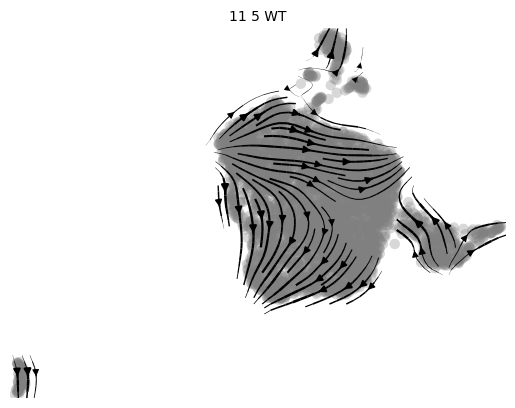

computing velocity embedding
    finished (0:00:01) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


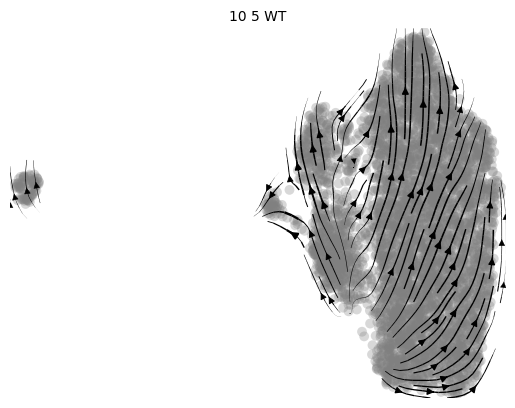

computing velocity embedding
    finished (0:00:01) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


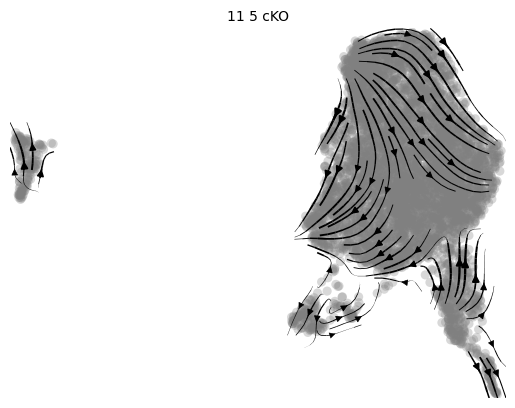

computing velocity embedding
    finished (0:00:01) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


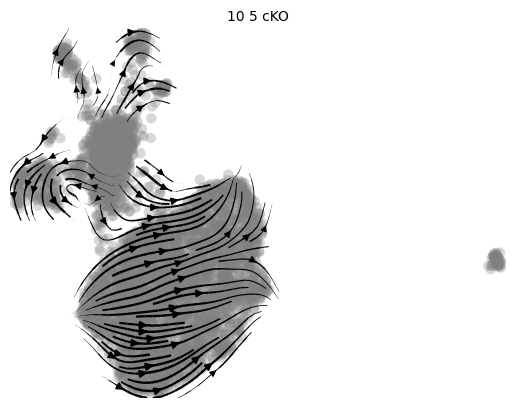

In [ ]:
# Deploy RNA velocity plots
# UMAP Embedding with Velocity
for key, adata in adata_dict.items():
    scv.pl.velocity_embedding_stream(adata, basis="umap", title=key)

In [ ]:
# Compute Leiden clustering
for key, adata in adata_dict.items():
    print(f"Computing Leiden clustering for {key}...")

    # Compute neighbors if not done
    if 'distances' not in adata.obsp:
        sc.pp.neighbors(adata, n_pcs=30, n_neighbors=30)

    # Perform Leiden clustering
    sc.tl.leiden(adata, resolution=0.5)  # Adjust resolution as needed

    # Verify clusters
    print(f"Leiden clusters for {key}:", adata.obs['leiden'].value_counts())

Computing Leiden clustering for 11_5_WT...
Leiden clusters for 11_5_WT: leiden
0    1493
1     891
2     711
3     599
4     317
5     108
6      83
7      62
Name: count, dtype: int64
Computing Leiden clustering for 10_5_WT...
Leiden clusters for 10_5_WT: leiden
0    1731
1    1165
2     955
3     538
4     277
5      78
6      41
Name: count, dtype: int64
Computing Leiden clustering for 11_5_cKO...
Leiden clusters for 11_5_cKO: leiden
0    1475
1    1196
2    1068
3    1063
4     420
5     169
6     149
Name: count, dtype: int64
Computing Leiden clustering for 10_5_cKO...
Leiden clusters for 10_5_cKO: leiden
0    974
1    863
2    785
3    772
4    428
5    190
6    118
7     80
8     44
Name: count, dtype: int64


In [ ]:
print(f"Type of rank_genes_groups['names']: {type(markers_dict['names'])}")
print(f"Keys in rank_genes_groups: {markers_dict.keys()}")
print(f"First entry in rank_genes_groups['names']: {markers_dict['names'][0]}")

In [ ]:
# Conduct markers identification for Leiden clusters
import scanpy as sc
import pandas as pd

# Perform differential expression analysis for each dataset
for key, adata in adata_dict.items():
    print(f"Performing differential expression analysis for {key}...")

    # Run differential expression analysis
    sc.tl.rank_genes_groups(adata, groupby='leiden', method='wilcoxon', key_added='rank_genes')

    # Check if rank_genes_groups results exist
    if 'rank_genes' not in adata.uns or 'names' not in adata.uns['rank_genes']:
        print(f"Warning: No differential expression results found for {key}. Skipping...")
        continue

    # Convert results to a DataFrame
    markers_dict = adata.uns['rank_genes']

    # Extract genes and ensure they are lists
    n_clusters = len(markers_dict['names'])  # Number of Leiden clusters
    marker_genes = []

    for i in range(n_clusters):
        cluster_name = str(i)  # Convert cluster index to string
        for gene_idx, gene in enumerate(markers_dict['names'][i]):  # Iterate through gene rankings
            marker_genes.append({
                'cluster': cluster_name,
                'gene': gene,
                'logfoldchange': markers_dict['logfoldchanges'][i][gene_idx],
                'pvals': markers_dict['pvals'][i][gene_idx],
                'pvals_adj': markers_dict['pvals_adj'][i][gene_idx]
            })

    # Create DataFrame
    if marker_genes:
        markers_df = pd.DataFrame(marker_genes)
        markers_df.to_csv(f"{key}_leiden_markers.csv", index=False)
        print(f"Marker genes for {key} saved to {key}_leiden_markers.csv")
    else:
        print(f"No marker genes identified for {key}. Skipping CSV export.")


Performing differential expression analysis for 11_5_WT...
Marker genes for 11_5_WT saved to 11_5_WT_leiden_markers.csv
Performing differential expression analysis for 10_5_WT...
Marker genes for 10_5_WT saved to 10_5_WT_leiden_markers.csv
Performing differential expression analysis for 11_5_cKO...
Marker genes for 11_5_cKO saved to 11_5_cKO_leiden_markers.csv
Performing differential expression analysis for 10_5_cKO...
Marker genes for 10_5_cKO saved to 10_5_cKO_leiden_markers.csv


In [ ]:
!pwd

/content/drive/MyDrive/jj/projects/2025/CarlySullivan/iteration2_all_with_cellranger/RNAvelocity


Plotting RNA velocity for 11_5_WT with Leiden clusters...


/usr/local/lib/python3.11/dist-packages/scvelo/plotting/utils.py:68: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/usr/local/lib/python3.11/dist-packages/scvelo/plotting/utils.py:68: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/usr/local/lib/python3.11/dist-packages/scvelo/plotting/utils.py:68: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/usr/local/lib/python3.11/dist-packages/scvelo/plotting/utils.py:68: DeprecationWarning: is_categorical_dtype is deprecated and wi

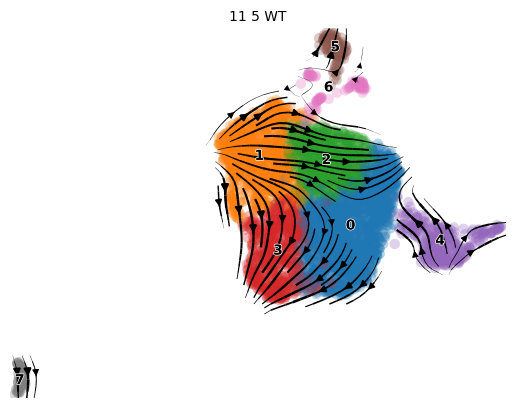

Plotting RNA velocity for 10_5_WT with Leiden clusters...


/usr/local/lib/python3.11/dist-packages/scvelo/plotting/utils.py:68: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/usr/local/lib/python3.11/dist-packages/scvelo/plotting/utils.py:68: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/usr/local/lib/python3.11/dist-packages/scvelo/plotting/utils.py:68: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/usr/local/lib/python3.11/dist-packages/scvelo/plotting/utils.py:68: DeprecationWarning: is_categorical_dtype is deprecated and wi

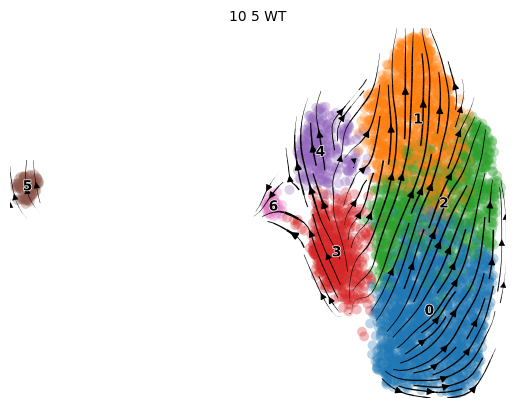

Plotting RNA velocity for 11_5_cKO with Leiden clusters...


/usr/local/lib/python3.11/dist-packages/scvelo/plotting/utils.py:68: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/usr/local/lib/python3.11/dist-packages/scvelo/plotting/utils.py:68: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/usr/local/lib/python3.11/dist-packages/scvelo/plotting/utils.py:68: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/usr/local/lib/python3.11/dist-packages/scvelo/plotting/utils.py:68: DeprecationWarning: is_categorical_dtype is deprecated and wi

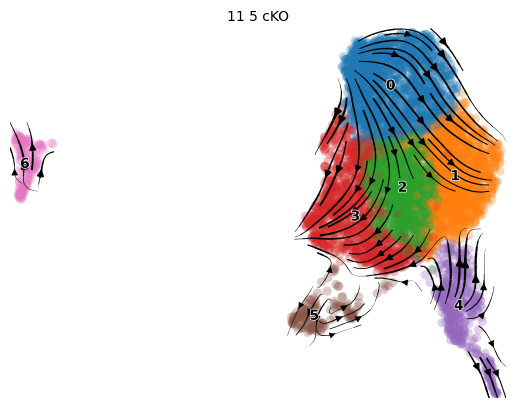

Plotting RNA velocity for 10_5_cKO with Leiden clusters...


/usr/local/lib/python3.11/dist-packages/scvelo/plotting/utils.py:68: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/usr/local/lib/python3.11/dist-packages/scvelo/plotting/utils.py:68: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/usr/local/lib/python3.11/dist-packages/scvelo/plotting/utils.py:68: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/usr/local/lib/python3.11/dist-packages/scvelo/plotting/utils.py:68: DeprecationWarning: is_categorical_dtype is deprecated and wi

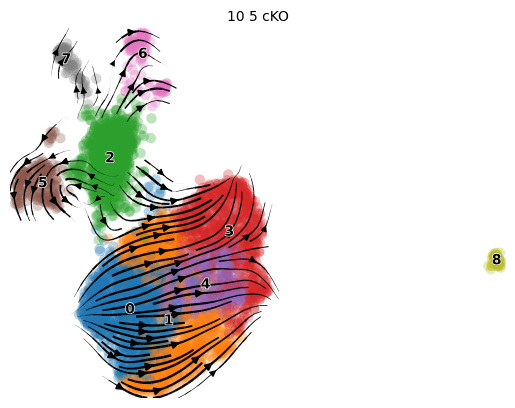

In [ ]:
# Rerun velocity plotting with leiden coloring
for key, adata in adata_dict.items():
    print(f"Plotting RNA velocity for {key} with Leiden clusters...")
    scv.pl.velocity_embedding_stream(adata, basis="umap", color="leiden", title=key)

In [ ]:
for key, adata in adata_dict.items():
    print(f"Available genes in {key}: {adata.var_names[:10]}")  # Show first 10 gene names


Available genes in 11_5_WT: Index(['Tmlhe', 'Snhg6', 'Tram1', 'Ube2w', 'Jph1', 'Fam135a', 'Uggt1',
       'Kansl3', 'Mitd1', 'Aff3'],
      dtype='object', name='Gene')
Available genes in 10_5_WT: Index(['Snhg6', 'Cops5', 'Tram1', 'Eya1', 'Prim2', 'Zfp451', 'Fam168b',
       'Uggt1', 'Tex30', 'Poglut2'],
      dtype='object', name='Gene')
Available genes in 11_5_cKO: Index(['Snhg6', 'Arfgef1', 'Ube2w', 'Jph1', 'Mcm3', 'Tram2', 'Kcnq5', 'Adgrb3',
       'Uggt1', 'Aff3'],
      dtype='object', name='Gene')
Available genes in 10_5_cKO: Index(['CAAA01118383.1', 'Vamp7', 'Cops5', 'Ncoa2', 'Eya1', 'Bag2', 'Txndc9',
       'Hecw2', 'Rftn2', 'Tmem237'],
      dtype='object', name='Gene')


Plotting velocity for 11_5_WT - Uggt1


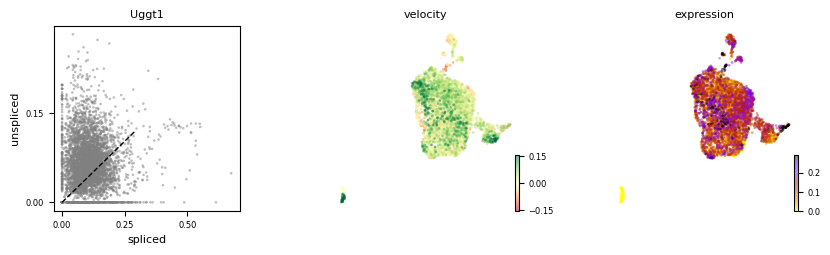

Plotting velocity for 10_5_WT - Uggt1


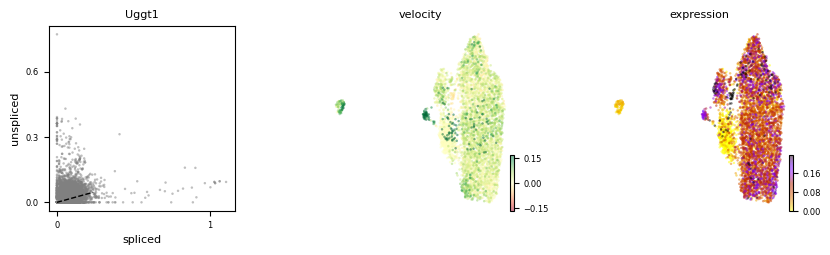

Plotting velocity for 11_5_cKO - Uggt1


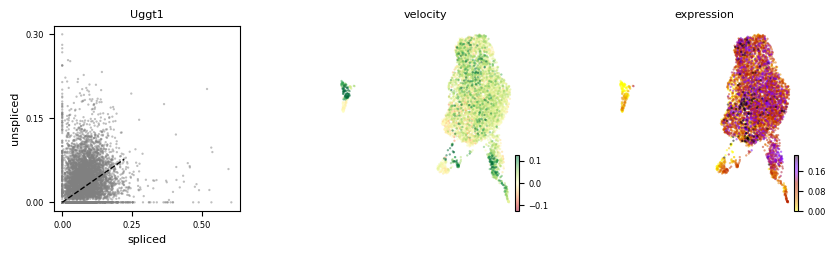

Skipping 10_5_cKO, Uggt1 not found.


In [ ]:
# Phase Portraits (to check splicing kinetics)
for key, adata in adata_dict.items():
    if "Uggt1" in adata.var_names:  # Ensure the gene exists in the dataset
        print(f"Plotting velocity for {key} - Uggt1")
        scv.pl.velocity(adata, var_names=["Uggt1"])  # Removed title argument
    else:
        print(f"Skipping {key}, Uggt1 not found.")


In [ ]:
# Combine Data for Comparative Analysis
adata_combined = adata_dict["11_5_WT"].concatenate(
    adata_dict["10_5_WT"],
    adata_dict["11_5_cKO"],
    adata_dict["10_5_cKO"],
    batch_key="condition",
    batch_categories=["11_5_WT", "10_5_WT", "11_5_cKO", "10_5_cKO"]
)

# Run UMAP
sc.pp.neighbors(adata_combined)
sc.tl.umap(adata_combined)

# Run velocity on combined data
scv.tl.velocity(adata_combined, mode="stochastic")
scv.tl.velocity_graph(adata_combined)

# Plot combined velocity
scv.pl.velocity_embedding_stream(adata_combined, basis="umap", legend_loc="right", title="Combined RNA Velocity")

ValueError: cannot reindex on an axis with duplicate labels

In [ ]:
# Differential velocity analysis
scv.tl.rank_velocity_genes(adata_combined, groupby="condition", min_corr=.3)
scv.pl.rank_velocity_genes(adata_combined, groupby="condition", n_genes=10)

NameError: name 'adata_combined' is not defined